# Initialization and API Functions

## Initialize Packages

In [ ]:
# EE4211 Data Science for the Internet of Things
# Final Project
# Question 1 due 29 October 2023
# Question 2 due 9 November 2023
# Question 3 due 17 November 2023

# Import widely used packages.
import numpy as np
import pandas as pd
import json
import requests
import random
import time
import os
from dateutil.parser import parse

# Save into folder. WE WILL NEED TO CHANGE THIS LATER TO WORK WITHOUT GOOGLE DRIVE.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
shared_path = '/content/drive/My Drive/EE4211_proj_copy'

Mounted at /content/drive


In [ ]:
# Question 1: Data Cleaning and Exploration of Data
# Carpark availability file at:
# https://beta.data.gov.sg/datasets/d_ca933a644e55d34fe21f28b8052fac63/view

# Supplementary information of carparks:
# https://beta.data.gov.sg/datasets/d_23f946fa557947f93a8043bbef41dd09/view

## API Functions

In [ ]:
# Function for API calls (without saving to JSON file).
# Will run for a max of max_num_tries times.

def get_df(year, month, day, hour, minute, second):
  max_num_tries = 5
  num_tries = 0
  while num_tries < max_num_tries:
    try:
      # Get carpark information for one instance.
      site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
      # print(f'API call from: {site}')
      response_API = requests.get(site)
      data = response_API.text
      data = json.loads(data)
      timestamp = data["items"][0]["timestamp"]
      print(f'Timestamp Received from API Call: {timestamp}')

      # Process data.
      data = data["items"][0]["carpark_data"]
      df = pd.json_normalize(data)
      for heading in ("total_lots","lot_type","lots_available"):
          df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
      df = df.drop(["carpark_info"], axis=1)

    except Exception as e:
      num_tries += 1
      print(f'Exception found: {e}. Retrying ({num_tries}/{max_num_tries})...')

    else:
      return df
  print(f'Could not get data after {max_num_tries}. Stopping...')

In [ ]:
# Function to download num_months worth of data in min_interval minute intervals.

def get_json(start_month=1, num_months=1, minute_interval=30):
  year = "2022"  # Set default year to 2022.
  month = str(start_month)
  day = "1"  # Set default day to 1st of the month.
  hour = "1" # Set default hour to 01:00hrs.
  minute = "00"
  second = "0"

  months_dct = {
    '1': 31,
    '2': 28,
    '3': 31,
    '4': 30,
    '5': 31,
    '6': 30,
    '7': 31,
    '8': 31,
    '9': 30,
    '10': 31,
    '11': 30,
    '12': 31
  }

  data = []
  full_list = []
  max_num_tries = 5
  num_tries = 0
  initial_month = month
  count = 0

  exit_flag = False

  while int(month) < int(initial_month) + num_months:
    while int(day) <= months_dct[month]:
      while int(hour) < 24:
        while int(minute) < 60:
          while num_tries < max_num_tries and not exit_flag:
            try:
              # Get carpark information for one instance.
              site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
              response_API = requests.get(site)
              data = response_API.text
              data = json.loads(data)
              timestamp = data["items"][0]["timestamp"]
              print(f'Timestamp Received from API Call: {timestamp}')
            except Exception as e:
              num_tries += 1
              print(f'Exception found: {e}. Retrying ({num_tries}/{max_num_tries})...')
              if num_tries >= max_num_tries:
                exit_flag = True
                print(f'Max retries reached! Stopping...')
            else:
              num_tries = 0
              # Process data.
              count += 1
              data = data["items"]
              full_list.append(data)
              minute = str(int(minute) + minute_interval)
              break
        if exit_flag:
          break
        minute = '1'
        hour = str(int(hour) + 1)
        print(f'Current Hour = {hour}')
      if exit_flag:
        break
      hour = '1'
      day = str(int(day) + 1)
      print(f'Current Day = {day}')
    if exit_flag:
      break
    day = '1'
    month = str(int(month) + 1)
  print(f'Current Month = {month}')

  if not exit_flag:
    print(f'Finished iterating!')
  else:
    print(f'Data was not scraped!')

  if full_list and not exit_flag:
      filepath = f"{shared_path}/ee4211_data_{start_month}_{num_months}_{minute_interval}.json"
      with open(filepath, 'w') as fp:
        json.dump(full_list, fp, indent=4)
        print('File created.')
      return filepath
  else:
      return None

In [ ]:
# Example:
# get_json(2, 30)
# will get 2 months of data at 30 minute intervals.

## Initialize JSON File

In [ ]:
# Being used for Questions 1.4 - 1.6
# Check for JSON file. If it does not exist, create it.

# Parameters for API Call.
start_month = "4"
num_months = 1
minute_interval = 60

# Write into filesystem as we can reuse in future questions and is also a long process to get the data.
path = f"{shared_path}/ee4211_data_{start_month}_{num_months}_{minute_interval}.json"

# If file does not exist, call API and create one.
if (not os.path.exists(path)):
  print(f"Creating json for {num_months} at {minute_interval} min intervals.")
  json = get_json(start_month, num_months, minute_interval) # Double check with Arvind.
  if json == None:
    raise Exception("Creating json failed.")
else:
  print(f'JSON at path ({path}) successfully loaded.')

JSON at path (/content/drive/My Drive/EE4211_proj_copy/ee4211_data_4_1_60.json) successfully loaded.


---

# **Question 1.1: Lot Type**
> Question: Look at the features in the dataset. What do the values in the column “lot type” mean?

> Hint: Note that data.gov.sg gets its data from the Land Transport Authority (LTA) too.
Try searching for the LTA Datamall API documentation.

## Question 1.1 Code

In [ ]:
# Question 1.1: Lot Type

# Change these values for different dates.
year = "2022"
month = "4"
day = "12"
hour = "12"
minute = "30"
second = "0"

df = get_df(year, month, day, hour, minute, second)

# Get unique lot types.
lot_types = pd.unique(df['lot_type'])

# Display data.
print(f'Unique lot types: {lot_types}')
df  # Display DataFrame.

Timestamp Received: 2022-04-12T12:29:27+08:00
Unique lot types: ['C' 'Y' 'H']


carpark_number      update_datetime total_lots lot_type lots_available
0              HE12  2022-04-12T12:12:32        105        C              0
1               HLM  2022-04-12T12:12:42        583        C              0
2               RHM  2022-04-12T12:12:32        329        C            106
3              BM29  2022-04-12T12:12:32         97        C              1
4               Q81  2022-04-12T12:12:32         96        C              0
...             ...                  ...        ...      ...            ...
1961           B65M  2022-04-12T12:11:58        679        C            499
1962           B65L  2022-04-12T12:11:58          5        C              0
1963            BE3  2022-04-12T11:30:52        306        C            148
1964           BE3R  2022-04-12T11:30:52        195        C            150
1965            B8B  2022-04-12T12:11:45        249        C            172

[1966 rows x 5 columns]

## Question 1.1 Answer:

According to LTA DataMall | API User Guide & Documentation Version 5 .5 (04 Apr 2023), lot_type refers to the type of the carpark lot. It is a categorial variable.

There are 3 possible values that lot_type can take:

'C' means the lot is for cars, 'H' means the lot is for heavy vehicles, 'Y'
means the lot is for motorcycles.


---



# **Question 1.2: Finding the Update Frequency of Sensors**



> Question: Try making an API call for the data from a single specified date & time. Then, make an API call for the next second of the initially chosen date & time. Notice that “up-date time” is unchanged. Carry out and document a systematic approach to approximate the frequency at which the data values are updated.

> Note: The purpose of this question is to avoid querying for data unnecessarily. Although the API date time parameter is specified to seconds, the database may not be updated every second.





## Question 1.2 Code

In [ ]:
# Question 1.2: Finding the Update Frequency of Sensors
# Make a query for the first second.

# Query for
# 2020-10-10T10:10:10+08:00
# returned
# 2020-10-10T10:09:27+08:00

# We will start sampling from timestamp:
# 2020-10-10T10:09:27+08:00

# Set the beginning to be: 2020-10-10T10:09:27+08:00.
year = "2020"
month = "10"
day = "10"
hour = "10"
minute = "09"
second = "27"

df = get_df(year, month, day, hour, minute, second)

# Display data.
df

Timestamp Received: 2020-10-10T10:08:27+08:00


carpark_number      update_datetime total_lots lot_type lots_available
0              HE12  2020-10-10T09:46:39         91        C              0
1               HLM  2020-10-10T09:46:35        583        C            337
2               RHM  2020-10-10T09:46:39        322        C             68
3              BM29  2020-10-10T09:46:31         97        C              3
4               Q81  2020-10-10T09:46:47         96        C              0
...             ...                  ...        ...      ...            ...
2057            TRM  2020-10-10T09:28:54         77        Y             40
2058           S39L  2020-10-10T09:47:12          5        C              2
2059           HG3L  2020-10-10T09:44:10        500        C            500
2060           HG3E  2020-10-10T09:44:07        500        C            500
2061            HG1  2020-10-10T02:47:35        500        C            487

[2062 rows x 5 columns]

In [ ]:
# Question 1.2: Finding the Update Frequency of Sensors
# Make a query for the next second.

# Previous timestamp:
# 2020-10-10T10:09:27+08:00

# Timestamp to query
# 2020-10-10T10:09:28+08:00

year = "2020"
month = "10"
day = "10"
hour = "10"
minute = "09"
second = "28"  # Increase by 1 second.

df = get_df(year, month, day, hour, minute, second)

# Display data.
df

Timestamp Received: 2020-10-10T10:09:27+08:00


carpark_number      update_datetime total_lots lot_type lots_available
0              HE12  2020-10-10T09:46:39         91        C              0
1               HLM  2020-10-10T09:46:35        583        C            337
2               RHM  2020-10-10T09:46:39        322        C             68
3              BM29  2020-10-10T09:46:31         97        C              3
4               Q81  2020-10-10T09:46:47         96        C              0
...             ...                  ...        ...      ...            ...
2057            TRM  2020-10-10T09:28:54         77        Y             40
2058           S39L  2020-10-10T09:47:12          5        C              2
2059           HG3L  2020-10-10T09:44:10        500        C            500
2060           HG3E  2020-10-10T09:44:07        500        C            500
2061            HG1  2020-10-10T02:47:35        500        C            487

[2062 rows x 5 columns]

Yes, from above we can see that the update_datetime does not change between seconds.

**Systematic approach to approximate frequency at which data values are updated:**

Idea: Query only one row first. Check second by second or minute by minute or hour by hour until the timing changes.



In [ ]:
# Question 1.2: Finding the Update Frequency of Sensors
# Try check for changes in seconds.

year = "2020"
month = "10"
day = "10"
hour = "10"
minute = "09"
second = "28"

prev_data = None

# Get first data.
df = get_df(year, month, day, hour, minute, second)
prev_data = df.iloc[0]  # Get first carpark info lot.

next_second = int(second) + 1

# Iterate through ~ 30 seconds of data.
print("Checking for changes in seconds of data...")
while(next_second) < 60:
  print(f'Currently checking for {next_second}th second...')
  df = get_df(year, month, day, hour, minute, str(next_second))
  new_data = df.iloc[0]  # Get first carpark info lot.

  # Compare prev and next update_time until a difference is found.
  diff_flag = False
  if (prev_data[1] != new_data[1]):
    diff_flag = True
    print('===========================')
    print('Change found!')
    print(f'Previous update_datetime: {prev_data[1]}')
    print(f'New update_datetime: {new_data[1]}')
    break

  next_second += 1

if not diff_flag:
  print('===========================')
  print("No difference found!")

API call from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2020-10-10T10%3A09%3A28
Timestamp Received: 2020-10-10T10:09:27+08:00
Checking for changes in seconds of data...
Currently checking for 29th second...
API call from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2020-10-10T10%3A09%3A29
Timestamp Received: 2020-10-10T10:09:27+08:00
Currently checking for 30th second...
API call from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2020-10-10T10%3A09%3A30
Timestamp Received: 2020-10-10T10:09:27+08:00
Currently checking for 31th second...
API call from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2020-10-10T10%3A09%3A31
Timestamp Received: 2020-10-10T10:09:27+08:00
Currently checking for 32th second...
API call from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2020-10-10T10%3A09%3A32
Timestamp Received: 2020-10-10T10:09:27+08:00
Currently checking for 33th second...
AP

From above, we can see that querying every 30 seconds does not result in a change in data. Let us try querying by every minute:

In [ ]:
# Question 1.2: Finding the Update Frequency of Sensors
# Try check for changes in minutes.

# start at 2020-10-10T10:10:10+08:00
year = "2020"
month = "10"
day = "10"
hour = "10"
minute = "00"
second = "00"

prev_data = None

# Get first data.
df = get_df(year, month, day, hour, minute, second)
prev_data = df.iloc[0]  # Get first carpark info lot.

next_minute = int(minute) + 1

# Iterate through ~ 60 minutes of data.
print("Checking for changes in minutes of data...")
while(next_minute) < 60:
  print(f'Currently checking for {next_minute}th minute...')
  df = get_df(year, month, day, hour, str(next_minute), second)
  new_data = df.iloc[0]  # Get first carpark info lot.

  # Compare prev and next update_time until a difference is found.
  diff_flag = False
  if (prev_data[1] != new_data[1]):
    diff_flag = True
    print('===========================')
    print('Change found!')
    print(f'Previous update_datetime: {prev_data[1]}')
    print(f'New update_datetime: {new_data[1]}')
    break

  next_minute += 1

if not diff_flag:
  print('===========================')
  print("No difference found!")

API call from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2020-10-10T10%3A00%3A00
Timestamp Received: 2020-10-10T09:59:27+08:00
Checking for changes in minutes of data...
Currently checking for 1th minute...
API call from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2020-10-10T10%3A01%3A00
Timestamp Received: 2020-10-10T10:00:27+08:00
Currently checking for 2th minute...
API call from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2020-10-10T10%3A02%3A00
Timestamp Received: 2020-10-10T10:01:27+08:00
Currently checking for 3th minute...
API call from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2020-10-10T10%3A03%3A00
Timestamp Received: 2020-10-10T10:02:27+08:00
Currently checking for 4th minute...
API call from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2020-10-10T10%3A04%3A00
Timestamp Received: 2020-10-10T10:03:26+08:00
Currently checking for 5th minute...
API cal

From above, we can see that there is a change in update_time after about 30 minutes. Let's verify this:

In [ ]:
# Question 1.2: Finding the Update Frequency of Sensors
# Verify that update_time changes approx every 30 minutes.

# We will query on the same day
# start at 2020-10-10T10:10:10+08:00

# Do a random number selection for 30 sensors out of 2062 car parks
# number 30 chosen for better statistical significance

# Between 0 to 2061 choose 30 numbers.
random.seed(4211) # for results to be reproducible
random_numbers = random.sample(range(0, 2062), 30)

frequency_array = [] # to store update frequencies of sensors

# Obtain 30 values of first string and next string to do comparison.
for number in random_numbers:
  year = "2020"
  month = "10"
  day = "10"
  hour = "10"
  minute = "00"
  second = "00"

  prev_data = None

  # Get first data.
  df = get_df(year, month, day, hour, minute, second)
  prev_data = df.iloc[0]  # Get first carpark info lot.

  next_minute = int(minute) + 1

  # Iterate through ~ 60 minutes of data.
  print("Checking for changes in minutes of data...")
  while(next_minute) < 60:
    print(f'Currently checking for {next_minute - 1}th minute...')
    df = get_df(year, month, day, hour, str(next_minute), second)
    new_data = df.iloc[0]  # Get first carpark info lot.

    # Compare prev and next update_time until a difference is found.
    diff_flag = False
    if (prev_data[1] != new_data[1]):
      diff_flag = True
      print('===========================')
      print(f'Change found for row number {number}!')
      print(f'Previous update_datetime: {prev_data[1]}')
      print(f'New update_datetime: {new_data[1]}')

      prev_update_time = prev_data[1]
      new_update_time = new_data[1]

      # Convert timestamp strings to datetime objects.
      datetime1 = parse(prev_update_time)
      datetime2 = parse(new_update_time)

      # Find the difference in time.
      time_difference = datetime2 - datetime1

      # Convert time difference to minutes.
      minutes_difference = time_difference.total_seconds() / 60

      print(f"Update frequency in minutes: {minutes_difference}")
      print('===========================')

      # Append this number to the time difference array in seconds.
      if minutes_difference > 0: # there are some malfunctioning sensors which returned a negative timing
        frequency_array.append(minutes_difference)
      break

    # Jump by 15 mins
    next_minute += 15

  if not diff_flag:
    print('===========================')
    print(f"No difference found for row {number}!")
    print('===========================')


avg_frequency_minutes = sum(frequency_array) / len(frequency_array)
print(f"Average update frequency of a sensor is {avg_frequency_minutes} minutes.")

Timestamp Received from API Call: 2020-10-10T09:59:27+08:00
Checking for changes in minutes of data...
Currently checking for 0th minute...
Timestamp Received from API Call: 2020-10-10T10:00:27+08:00
Currently checking for 15th minute...
Timestamp Received from API Call: 2020-10-10T10:15:27+08:00
Currently checking for 30th minute...
Timestamp Received from API Call: 2020-10-10T10:30:27+08:00
Change found for row number 1856!
Previous update_time: 2020-10-10T09:46:39
New update_time: 2020-10-10T10:17:09
Update frequency in minutes: 30.5
Timestamp Received from API Call: 2020-10-10T09:59:27+08:00
Checking for changes in minutes of data...
Currently checking for 0th minute...
Timestamp Received from API Call: 2020-10-10T10:00:27+08:00
Currently checking for 15th minute...
Timestamp Received from API Call: 2020-10-10T10:15:27+08:00
Currently checking for 30th minute...
Timestamp Received from API Call: 2020-10-10T10:30:27+08:00
Change found for row number 186!
Previous update_time: 2020-1

## Question 1.2 Answer:

Our systematic approach to approximate frequency at which data values are updated is to query at random over 30 rows out of the 2062 rows as querying all 2062 rows will take unreasonable amount of time. For each randomly selected row, we find the update frequency of the row, if any update was even done (since some sensors malfunctioned). And then take the average of all frequencies collected. We obtained an average update frequency of roughly 30 minutes for every sensor.

---

# **Question 1.3: Unique Carparks**
> Question:
1.   How many unique carparks are included in the carpark availability dataset?
2.   Check if this value varies with time. Explain why this check is important (about 20 words).

## Question 1.3 Code

In [ ]:
# Question 1.3: Unique Carparks
# Do a query for 2020-10-10T10:10:10+08:00

year = "2020"
month = "10"
day = "10"
hour = "10"
minute = "09"
second = "28"

df = get_df(year, month, day, hour, minute, second)
print(f"number of rows in df: {len(df['carpark_number'])}")

# Check for unique carpark IDs.
# Column carpark_number will be useful.
print(f"number of unique carpark numbers: {len(df['carpark_number'].unique())}") # 1911

Timestamp Received from API Call: 2020-10-10T10:09:27+08:00
number of rows in df: 2062
number of unique carpark numbers: 1911


In [ ]:
# Question 1.3: Unique Carparks
# Do another query for 2022 i.e. 2 years after 2020
year = "2022"
month = "10"
day = "10"
hour = "10"
minute = "09"
second = "28"

df = get_df(year, month, day, hour, minute, second)
print(f"number of rows in df: {len(df['carpark_number'])}")

# Check for unique carpark IDs.
# Column carpark_number will be useful.
print(f"number of unique carpark numbers: {len(df['carpark_number'].unique())}") # 1966

Timestamp Received from API Call: 2022-10-10T10:09:27+08:00
number of rows in df: 1967
number of unique carpark numbers: 1966


## Question 1.3 Answer:

In year 2020 it was 1911 unique carparks. In year 2022 it was 1966 unique carparks.

We found that for a same time, but two years later, the number of unique carparks changed. The check is important because we do not want to mismatch rows when dealing with data which may result in wrong labeling and therefore noise.

---

# **Question 1.4: Malfunctioning Sensors**
> Question: A carpark may have malfunctioning sensors. There are many types of possible malfunctions.
* Identify one of these carparks that you believe has a malfunctioning sensors
* Explain what the “malfunction” is in this case (about 20 words).

## Question 1.4 Code

In [ ]:
# Question 1.4: Malfunctioning Sensors
# Get the json file saved with April 2022's data

df = pd.read_json(path)
curr_timestamp = df[0][0]
j = 0

# Query the entries for 1 timestamp (April 1 2022, 1am) to find carparks where the update_datetime is not matching the current day.
for i in range(len(curr_timestamp['carpark_data'])):
  if curr_timestamp['carpark_data'][i]['update_datetime'][:10] != curr_timestamp["timestamp"][:10]:
    j = i
    break

curr_timestamp['carpark_data'][j]

## Question 1.4 Answer:
Malfunctioning sensors are sensors which have stopped updating their status.
For example, we happened to query a sensor belonging to carpark_number '*BM9*'. The query was in 2022, but the update_datetime was stuck in 2014. This implies that the sensor might be malfunctioning.

---

# **Question 1.5: Computing Availability Ratios for Carparks**
> Question: Create a dataset of hourly carpark availability (i.e., use the ratio: lots available/total lots) from the raw data. Select a one month interval and plot the average (average across all carparks) hourly carpark availability against time for that interval. Identify any patterns in the plot (about 50 words).

> Note: You will have to decide what to do if there are no carpark readings for a certain
hour. For example, some may impute the missing data or ignore it. You also have to
decide if you want to (i) compute the ratios for each carpark and then average OR (ii)
compute the total lots available and total total lots and take the ratio.
We will use April 2020 as the one month interval.


## Question 1.5 Code

JSON Structure:
>data[timestamp_num][0]["carpark_data"][carpark_num]["carpark_info"][lot_num]

In [ ]:
# Question 1.5: Computing Availability Ratios for Carparks
# Read the JSON file.

df = pd.read_json(path)

FileNotFoundError: ignored

In [ ]:
# Question 1.5: Computing Availability Ratios for Carparks
# Calculate the ratios from the JSON file.

plot_data_points = []
for timestamp in range(df.shape[0]):
  data = df[0][timestamp]['carpark_data']
  # Convert list to dataframe.
  df_new = pd.DataFrame(data)

  for heading in ("total_lots","lot_type","lots_available"):
      df_new[heading] = df_new["carpark_info"].apply(lambda x: x[0][heading])
  df_new = df_new.drop(["carpark_info"], axis=1)
  # Data clean on df.
  df_new.dropna(inplace = True)

  total_lots_sum = 0
  lots_available_sum = 0

  for i in range(1, len(df_new['total_lots'])):
    total_lots_sum += int(df_new['total_lots'][i])
    lots_available_sum += int(df_new['lots_available'][i])

  # Calculate the ratio.
  ratio = lots_available_sum / total_lots_sum

  # Save the data points.
  time = df[0][timestamp]['timestamp']
  hour = time[11:13]
  plot_data_points.append((hour, ratio))

[('00', 0.4580292401640471),
 ('02', 0.45101388858050045),
 ('03', 0.4479935082049077),
 ('04', 0.4467794312509202),
 ('05', 0.4469665405618608),
 ('06', 0.45459495348236384),
 ('07', 0.5029153244330696),
 ('08', 0.576144672096967),
 ('09', 0.6313238353698678),
 ('10', 0.6571294448356367),
 ('11', 0.6675873580600769),
 ('12', 0.669549394377153),
 ('13', 0.6673681929377836),
 ('14', 0.6744400237826664),
 ('15', 0.672310187945939),
 ('16', 0.6692459005462233),
 ('17', 0.6621893636617476),
 ('18', 0.6459757510982795),
 ('19', 0.6073458054215404),
 ('20', 0.5883444748549337),
 ('21', 0.559004712054231),
 ('22', 0.5408516878766185),
 ('23', 0.5155549568666226),
 ('01', 0.4738143390523602),
 ('02', 0.46180359150613387),
 ('03', 0.4546991097593156),
 ('04', 0.45212654398579943),
 ('05', 0.44989707492917397),
 ('06', 0.45194509122502174),
 ('07', 0.46734407751356905),
 ('08', 0.5000832805889603),
 ('09', 0.5398975592882218),
 ('10', 0.5697609118710036),
 ('11', 0.5922230227512192),
 ('12', 0.6

Given that we now have the ratios for each carpark for each hour, we will calculate the total average ratio for each hour:

In [ ]:
# Question 1.5: Computing Availability Ratios for Carparks
# Calculate the ratios from the JSON file.

plot_total_ratios = {}
plot_total_counts = {}
plot_data_points_v2 = []

for point in plot_data_points:
    plot_total_counts[point[0]] = plot_total_counts.get(point[0], 0) + 1
    plot_total_ratios[point[0]] = plot_total_ratios.get(point[0], 0) + point[1]

for key, value in plot_total_ratios.items():
  plot_data_points_v2.append((key, value / plot_total_counts[key]))

plot_data_points_v2

[('00', 0.4580292401640471),
 ('02', 0.4569812302629608),
 ('03', 0.45309373328756286),
 ('04', 0.451304250992948),
 ('05', 0.4505887814895155),
 ('06', 0.45576272629913167),
 ('07', 0.49149485962520845),
 ('08', 0.5500601270579502),
 ('09', 0.5978545561271287),
 ('10', 0.6228754329090104),
 ('11', 0.6361796970802087),
 ('12', 0.6427293767699876),
 ('13', 0.6410446954691996),
 ('14', 0.6464461221776522),
 ('15', 0.6468358646293634),
 ('16', 0.6447713499138366),
 ('17', 0.638725606610257),
 ('18', 0.6264458809921829),
 ('19', 0.5936940438002973),
 ('20', 0.5557590618291884),
 ('21', 0.5364412346801981),
 ('22', 0.5201529890020008),
 ('23', 0.49622783173771073),
 ('01', 0.46486048936714897)]

Text(0.5, 1.0, 'ratio against time')

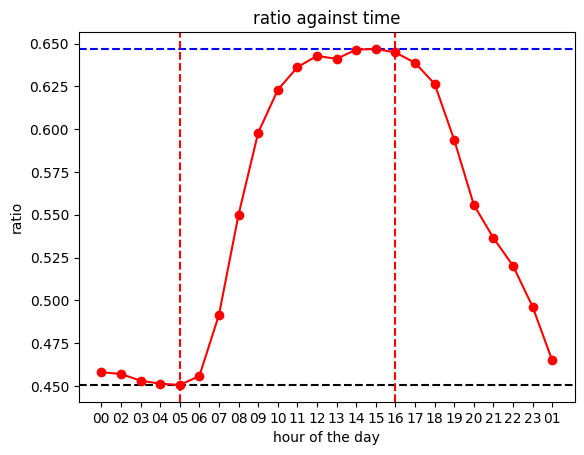

In [ ]:
# Question 1.5: Computing Availability Ratios for Carparks
# Plot the data.

import matplotlib.pyplot as plt
plot_data_points_v2
x = []
y = []
for point in plot_data_points_v2:
  x.append(point[0])
  y.append(point[1])
max_y = max(y)
min_y = min(y)
plt.axhline(max_y, color='blue', linestyle='--', label='max_ratio')
plt.axvline(x=4, color='red', linestyle='--', label='hour = 4')
plt.axhline(min_y, color='black', linestyle='--', label='min_ratio')
plt.axvline(x=15, color='red', linestyle='--', label='hour = 15')

plt.plot(x, y, label='Tuple Point', color='red', marker='o')
plt.xlabel('hour of the day')
plt.ylabel('ratio')
plt.title('ratio against time')

## Question 1.5 Answer:
We chose the approach to ignore missing carpark data.

Plot as shown above. Ratio against hour of the day shows a non-linear relationship. Ratio is the minimum at 5am, where carparks are generally least filled. Ratio is maximum at 4pm when the carparks are generally most filled.

The relationship looks sinusoidal.

---

# **Question 1.6: Pick a Carpark and it's Correlated Carpark**

> Question: Intuitively, we expect that carpark availability across certain carparks to be correlated. For example, many housing carparks would experience higher carpark availability during working hours. Using the same interval chosen in 1.5, pick a carpark and find the carpark that is most correlated to it (in terms of carpark availability). State the type of correlation used (e.g. Spearman, Pearson, etc).

## Question 1.6 Code

In [ ]:
# Question 1.6: Pick a Carpark and it's Correlated Carpark
# Process data into a new DataFrame with required information.

import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import spearmanr
import warnings

ratios_list = []
for timestamp in range(df.shape[0]):
    data = df[0][timestamp]['carpark_data']
    df_new = pd.DataFrame(data)

    for heading in ("total_lots", "lot_type", "lots_available"):
        df_new[heading] = df_new["carpark_info"].apply(lambda x: x[0][heading])
    df_new = df_new.drop(["carpark_info"], axis=1)
    df_new.dropna(inplace=True)

    # Obtain Carpark Availability Ratios and Store in List
    for i in range(1, len(df_new['total_lots'])):
        carpark_number = df_new['carpark_number'][i]
        total_lots = int(df_new['total_lots'][i])
        lots_available = int(df_new['lots_available'][i])
        if not (total_lots == 0):
            ratio = (lots_available / total_lots)
        else:
            ratio = 0
        time = df[0][timestamp]['timestamp']
        hour = time[11:13]
        day = time[8:10]
        ratios_list.append((carpark_number, day, hour, ratio))

# Create New DataFrame to Contain Carpark Hourly Availability Ratios
df_new = pd.DataFrame(ratios_list, columns=['Name', 'Day', 'Hour', 'Ratio'])
hourly_averages = df_new.groupby(['Name', 'Hour'])['Ratio'].mean().reset_index()
hourly_averages['Ratio'] = hourly_averages['Ratio'].apply(lambda x: round(x, 5))

# Interpolate and Fill Missing Data
for name in hourly_averages['Name'].unique():
    name_data = hourly_averages[hourly_averages['Name'] == name]
    name_data = name_data.set_index('Hour').reindex(range(24))
    name_data['Ratio'] = name_data['Ratio'].interpolate()
    name_data['Ratio'] = name_data['Ratio'].ffill().bfill()

    name_data = name_data.reset_index()
    hourly_averages.update(name_data)

Reference: KJ4 

Hour Availability
00 0.3956
01 0.40186
02 0.3978
03 0.39304
04 0.39212
05 0.38315
06 0.36758
07 0.3815
08 0.27051
09 0.35201
10 0.33663
11 0.34267
12 0.36319
13 0.34817
14 0.44707
15 0.52637
16 0.55055
17 0.56612
18 0.56392
19 0.54341
20 0.48297
21 0.46264
22 0.45183
23 0.43993

Best Match: ('GM2A', 0.9747826086956521)
Hour Availability
00 0.25342
01 0.28011
02 0.2637
03 0.25548
04 0.25936
05 0.22968
06 0.21347
07 0.25457
08 0.19132
09 0.22877
10 0.20913
11 0.19772
12 0.19612
13 0.21575
14 0.33082
15 0.41142
16 0.43676
17 0.44977
18 0.46233
19 0.44612
20 0.43014
21 0.4032
22 0.38311
23 0.34338


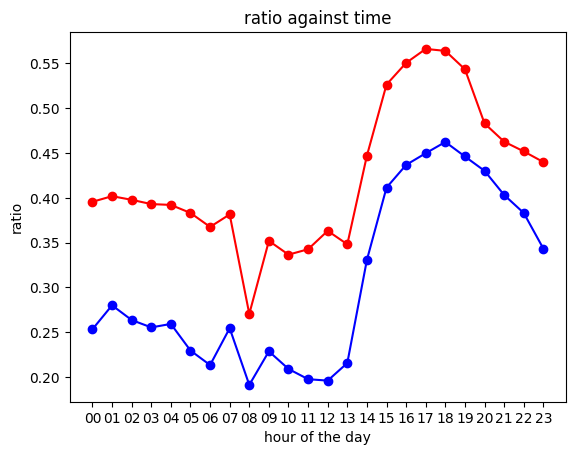

In [ ]:
# Question 1.6: Pick a Carpark and it's Correlated Carpark
# Get best match to reference carpark.

# Set Reference Carpark
reference_carpark_name = "KJ4"
reference_carpark_data = hourly_averages[hourly_averages['Name'] == reference_carpark_name][['Name', 'Hour', 'Ratio']]
reference_carpark_data['Ratio'] = reference_carpark_data['Ratio']
print("Reference:", reference_carpark_name)
print("Hour", "Availability")
for index, row in reference_carpark_data.iterrows():
    hour = row['Hour']
    availability = float(row['Ratio'])
    print(hour, availability)

# Initialise Correlations List and Correlation Variable
correlations = []
correlation = None

# Calculate Spearman's Correlation between Every Carpark and Reference Carpark.
for carpark_name in hourly_averages['Name'].unique():
    if carpark_name == reference_carpark_name:
        continue  # Skip the reference carpark itself

    carpark_data = hourly_averages[hourly_averages['Name'] == carpark_name][['Name', 'Hour', 'Ratio']]

    try:
        correlation, _ = spearmanr(reference_carpark_data['Ratio'], carpark_data['Ratio'])
    except:
      warnings.filterwarnings("ignore", category=ss.ConstantInputWarning)
      continue

    correlations.append((carpark_name, correlation))

# Get Carpark with Highest Correlation.
best_match = max(correlations, key=lambda x: x[1])
best_carpark_name, best_correlation = best_match
print("\nName and Correlation Coefficient of Best Match:", best_match)
match_carpark_data = hourly_averages[hourly_averages['Name'] == best_carpark_name][['Name', 'Hour', 'Ratio']]
print("Hour", "Availability")
for index, row in match_carpark_data.iterrows():
    hour = row['Hour']
    availability = float(row['Ratio'])
    print(hour, availability)

x = []
y = []

# Plot Graph for Reference Carpark.
for index, row in reference_carpark_data.iterrows():
    name = row['Name']
    hour = row['Hour']
    average_ratio = float(row['Ratio'])
    x.append(hour)
    y.append(average_ratio)
max_y = max(y)
min_y = min(y)

plt.plot(x, y, color='red', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Ratio')
plt.title('Ratio Against Time')

a = []
b = []

# Plot Graph for Best Match Carpark.
for index, row in match_carpark_data.iterrows():
    name = row['Name']
    hour = row['Hour']
    average_ratio = float(row['Ratio'])
    a.append(hour)
    b.append(average_ratio)
max_b = max(b)
min_b = min(b)

plt.plot(a, b, color='blue', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Ratio')
plt.title('Ratio Against Time')
plt.show()

## Question 1.6 Answer:
The carpark chosen was "KJ4". We caclulated corellation using the spearman's coefficient as the pearson coefficient is used for linear relationships and based on the results of Q1.5 we see that the relationship between ratio of availability and time of day is non-linear. This makes the spearman coefficent more suited for our use case. After calculation, we find the most corellated carpark to "KJ4" was the carpark "GM2A", with a corellation coefficient of 0.9747.

Upon further inspection, we noticed both these carparks are present near hawker centers which would explain the similar graphs as well as the dip at 8am which would correspond to when people come to the hawker center for breakfast.

---

# **Question 1.7: Group Project Proposal for Question 3**
> Please include a short proposal (around 500
words) of what your team intends to do for the Group Proposed Project in Question 3. For the group project proposal, you may use additional datasets to supplement your
analysis or look at unaggregated data, etc. See Question 3 below for more information
about this. Please use markdown in the iPython notebook to present your proposal.

## Question 1.7 Answer:

**Project Proposal: Carpark Fullness Prediction Near Food Places**

We begin our final project with the basic functionalities and further adding additional functionalities as the project progreses. The basic functionality we propose is to build a carpark querying app. We can build a model using data points collected from question 1. Try out various machine learning models on these data, and find the best prediction model on the test data. In our attempts to explore the various machine learnin algorithms, we will explore bootstrapping, boosting and ensembling.  The inputs will be the query timestamp and carpark number. The output will be the probability that there will be a lot at a timestamp. This app can provide drivers with meaningful insight, like a peace of mind that there will be a carpark when they arrive. Also, the possibility for them to look for other carparks if the carpark with the predicted timestamp will be too full at the time of arrival.

Title: Parkan - Predict, View, and Navigate Carpark Spaces

Objective:
- To create a seamless dining experience by predicting carpark occupancy near food courts, visually representing this data via heatmaps, and guiding users to alternative parking spaces when primary options are full.

Background:
- In bustling urban environments, a significant fraction of traffic congestion arises from vehicles searching for parking. Particularly near food courts - hubs of culinary activity - parking can be a challenge. Parkan aims to mitigate this issue, ensuring that the journey to the food court is as enjoyable as the dining itself.

Scope:
- Predictive Analysis: Utilize machine learning to analyze historical and current carpark data to predict future occupancy trends, especially during peak dining hours.
- Visual Heatmap: Offer a graphical representation of carpark occupancy, giving users a quick visual cue of where parking might be available.
- Alternative Options: In cases where the desired carpark is predicted to be full, provide users with directions to the next nearest carpark.

Features:
- Time-based Predictions: Users input their planned dining time, and the system predicts carpark occupancy near their dining destination.
- Heatmap: A map that displays carpark fullness using colour gradients, allowing users to visually gauge parking availability at a glance.
- Smart Recommendations: If a carpark is anticipated to be full, the system automatically suggests the nearest alternative carpark, considering both distance and predicted availability.

Data Sources and Technology Stack:
- Carpark Availability Data: Historical and real-time data on carpark occupancy.
- Food Court Data: Information on food court locations.
- GIS (Geographical Information Systems): For heatmap creation, distance calculations, and route recommendations.
- Machine Learning: Time series forecasting models.

Benefits:
- For Patrons: Alleviate the stress of finding parking, allowing them to focus on their dining experience.
- For Food Courts: Potential increase in patronage as parking challenges are minimized.
- For Urban Traffic Management: Reduction in cars roaming around searching for parking, leading to decreased congestion and emissions.

---

# **Question 2.1: Why Forecast?**
> Question: In this part, you will build a model to forecast the hourly carpark availability in the future
(averaged across all carparks instead of looking at each carpark individually). Can you
explain why you may want to forecast the carpark availability in the future? Who would
find this information valuable? What can you do if you have a good forecasting model?

## Question 2.1 Answer:

Forecasting the hourly carpark availability in the future can prove useful especially for drivers. Drivers will be able to save time and fuel by avoiding carparks that are full, especially during peak hours. This allows the drivers to plan their trips better, further helping to alleviate traffic near carparks as drivers try to find parking spaces in already full carparks. This also means that less time is spent idling and driving around in cars, leading to reduced emissions.

A good forecasting model can be helpful in creating an app that could provide accurate parking availability predictions to users.



---



# Question 2.2 to 2.4: Generating Pre-requisite JSON Files & Dataframes

In [ ]:
# Imports for Question 2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Linear Regression
from sklearn.linear_model import LinearRegression

# Support Vector Regression
from sklearn.svm import SVR

# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

# Regression Metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [ ]:
# Question 2: Generating Pre-requisite JSON Files & Dataframes

# Get training and test datasets
# Check for JSON file. If it does not exist, create it.

# Parameters for API Call.
# Training (July 2022)
start_month = "7"
num_months = 1
minute_interval = 60

# Write into filesystem as we can reuse in future questions and is also a long process to get the data.
path = f"{shared_path}/ee4211_data_{start_month}_{num_months}_{minute_interval}.json"

# If file does not exist, call API and create one.
if (not os.path.exists(path)):
  print(f"Creating json starting at month {start_month} for {num_months} month at {minute_interval} min intervals.")
  json = get_json(start_month, num_months, minute_interval)
  if json == None:
    raise Exception("Creating json failed.")
else:
  print(f'JSON at path ({path}) present.')

JSON at path (/content/drive/My Drive/EE4211_proj_copy/ee4211_data_7_1_60.json) present.


In [ ]:
# Question 2: Generating Pre-requisite JSON Files & Dataframes

# Parameters for API Call.
# Test (Aug 2022)
start_month = "8"
num_months = 1
minute_interval = 60

# Write into filesystem as we can reuse in future questions and is also a long process to get the data.
path = f"{shared_path}/ee4211_data_{start_month}_{num_months}_{minute_interval}.json"

# If file does not exist, call API and create one.
if (not os.path.exists(path)):
  print(f"Creating json starting at month {start_month} for {num_months} month at {minute_interval} min intervals.")
  json = get_json(start_month, num_months, minute_interval)
  if json == None:
    raise Exception("Creating json failed.")
else:
  print(f'JSON at path ({path}) present.')

JSON at path (/content/drive/My Drive/EE4211_proj_copy/ee4211_data_8_1_60.json) present.


In [ ]:
# Question 2: Generating Pre-requisite JSON Files & Dataframes

def process_parking_data(df_load):
  data_points = []

  for timestamp in range(df_load.shape[0]):
    data = df_load[0][timestamp]['carpark_data']
    # Convert list to dataframe.
    df = pd.DataFrame(data)

    for heading in ("total_lots","lot_type","lots_available"):
        df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
    df = df.drop(["carpark_info"], axis=1)
    # Data clean on df.
    df.dropna(inplace = True)

    total_lots_sum = 0
    lots_available_sum = 0

    for i in range(1, len(df['total_lots'])):
      lots_available_sum += int(df['lots_available'][i])
      total_lots_sum += int(df['total_lots'][i])

    # Calculate the ratio.
    ratio = lots_available_sum / total_lots_sum

    # Save the data points.
    time = df_load[0][timestamp]['timestamp']
    data_points.append((time, ratio))

  # Parse the timestamp and ratio into separate lists.
  dates, times, ratios = [], [], []
  for timestamp, ratio in data_points:
      # Parse the timestamp with dateutil's parse function.
      dt = parse(timestamp)
      # Extract date and time
      dates.append(dt.strftime('%Y-%m-%d'))
      times.append(dt.strftime('%H:%M'))
      ratios.append(ratio)

  # Create a DataFrame.
  df = pd.DataFrame({
      'date': dates,
      'time': times,
      'ratio': ratios
  })

  return df

In [ ]:
# Question 2: Generating Pre-requisite JSON Files & Dataframes

# Training Dataset (July 2022).
df_train_load = pd.read_json(f'{shared_path}/ee4211_data_7_1_60.json')
df_train = process_parking_data(df_train_load)

# Test Dataset (August 2022).
df_test_load = pd.read_json(f'{shared_path}/ee4211_data_8_1_60.json')
df_test = process_parking_data(df_test_load)

# Function to create lagged features.
def create_lagged_features(df, n_lags):
    lagged_dfs = [df]  # Start with the original DataFrame in a list.
    for n in range(1, n_lags + 1):
        lagged_df = df[['ratio']].shift(n)  # Create a DataFrame of shifted values.
        lagged_df.rename(columns={'ratio': f'lag_{n}h'}, inplace=True)  # Rename the shifted column.
        lagged_dfs.append(lagged_df)  # Add the new DataFrame to the list.

    # Concatenate all the DataFrames in the list.
    df_with_lags = pd.concat(lagged_dfs, axis=1)
    return df_with_lags

# Merge the date and time columns and convert to datetime.
df_train['datetime'] = pd.to_datetime(df_train['date'] + ' ' + df_train['time'])
df_test['datetime'] = pd.to_datetime(df_test['date'] + ' ' + df_test['time'])

# Set the datetime as the index.
df_train = df_train.set_index('datetime')
df_test = df_test.set_index('datetime')

# Create lagged features for the last 10 days.
n_lags = 10 * 24
df_train = create_lagged_features(df_train, n_lags)
df_test = create_lagged_features(df_test, n_lags)

# Drop rows with NaN values that were created by shifting.
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

# The new feature matrix includes the lagged features plus the hour and day of week.
df_train['hour'] = df_train.index.hour
df_train['day_of_week'] = df_train.index.dayofweek
df_test['hour'] = df_test.index.hour
df_test['day_of_week'] = df_test.index.dayofweek

X_train = df_train.drop(['date', 'time', 'ratio'], axis=1)
y_train = df_train['ratio']

X_test = df_test.drop(['date', 'time', 'ratio'], axis=1)
y_test = df_test['ratio']

---

# **Question 2.2: Linear Regression Forecast**
> Question: Build a linear regression model to forecast the hourly carpark availability for a given
month. Use the month of July 2022 as a training dataset and the month of August 2022 as the test dataset. For this part, do not use additional datasets. The target is the hourly carpark availability percentage and you will have to decide what features you want to
use. Generate two plots: (i) Time series plot of the actual and predicted hourly values (ii) Scatter plot of actual vs predicted hourly values (along with a line showing how good
the fit is).

## Question 2.2 Code

Regression Metrics:
[Train] MSE: 6.453782913519944e-06, R2: 0.9990928009359937
[Cross Validation on Train] Mean R2 = 0.9945, Std = 0.0045
[Test] MSE: 1.8652950166020866e-05, R2: 0.9975614015889941


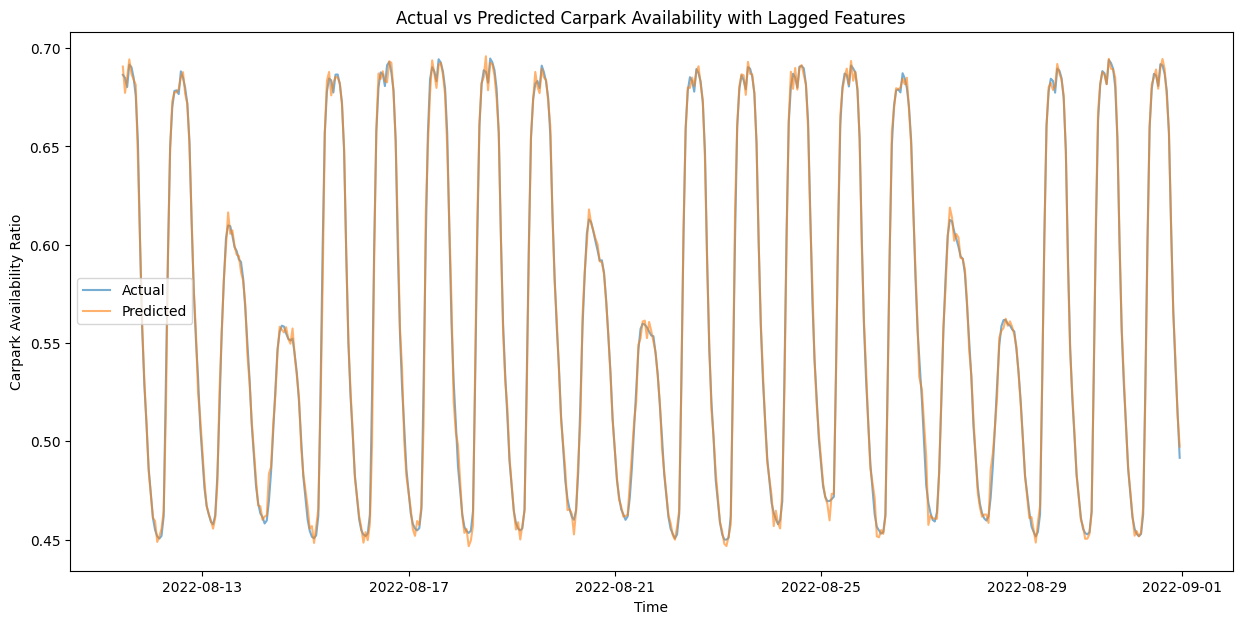

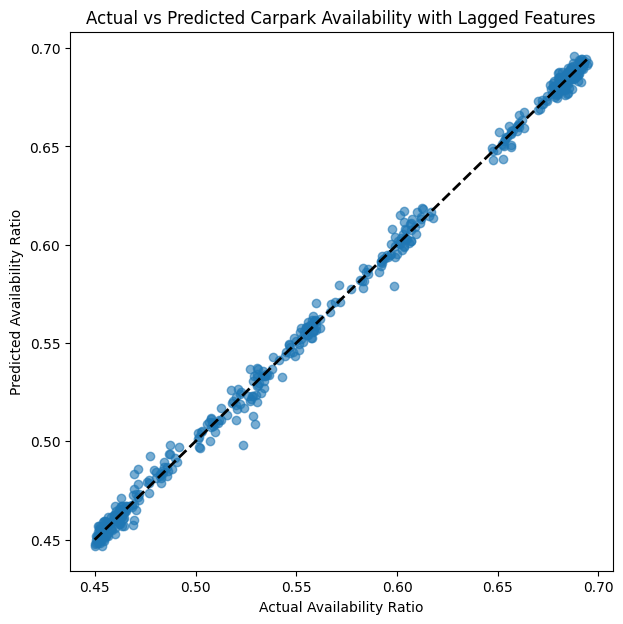

In [ ]:
# Question 2.2: Linear Regression Forecast

# Train the model.
model = LinearRegression() # No need for hyper-parameter tuning on LinearRegression.
model.fit(X_train, y_train)

# Evaluate the Model.
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Calculate metrics.
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)

# Perform 5-fold cross-validation to test for overfitting.
k = 5
scores_lr = cross_val_score(model, X_train, y_train, cv=k, scoring='r2')
mean_scores_lr = scores_lr.mean()
std_scores_lr = scores_lr.std()

print('Regression Metrics:')
print(f'[Train] MSE: {mse_train}, R2: {r2_train}')
print(f"[Cross Validation on Train] Mean R2 = {mean_scores_lr:.4f}, Std = {std_scores_lr:.4f}")
print(f'[Test] MSE: {mse_test}, R2: {r2_test}')
print('======================================================================')

# Visualization.
# (i) Time series plot of the actual and predicted hourly values.
plt.figure(figsize=(15, 7))
plt.plot(df_test.index, y_test, label='Actual', alpha=0.6)
plt.plot(df_test.index, predictions_test, label='Predicted', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Carpark Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.legend()
plt.show()

# (ii) Scatter plot of actual vs predicted hourly values.
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions_test, alpha=0.6)
plt.xlabel('Actual Availability Ratio')
plt.ylabel('Predicted Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()



---



# **Question 2.3: Support Vector Regressor (SVR) Forecast**
> Question: Do the same as Question 2.2 above but use support vector regressor (SVR).

## Question 2.3 Code

Regression Metrics:
[Train] MSE: 4.6842359852447465e-05, R2: 0.9934154362513555
[Cross Validation on Train] Mean R2 = 0.9803, Std = 0.0088
[Test] MSE: 7.409161480740512e-05, R2: 0.99031361299258


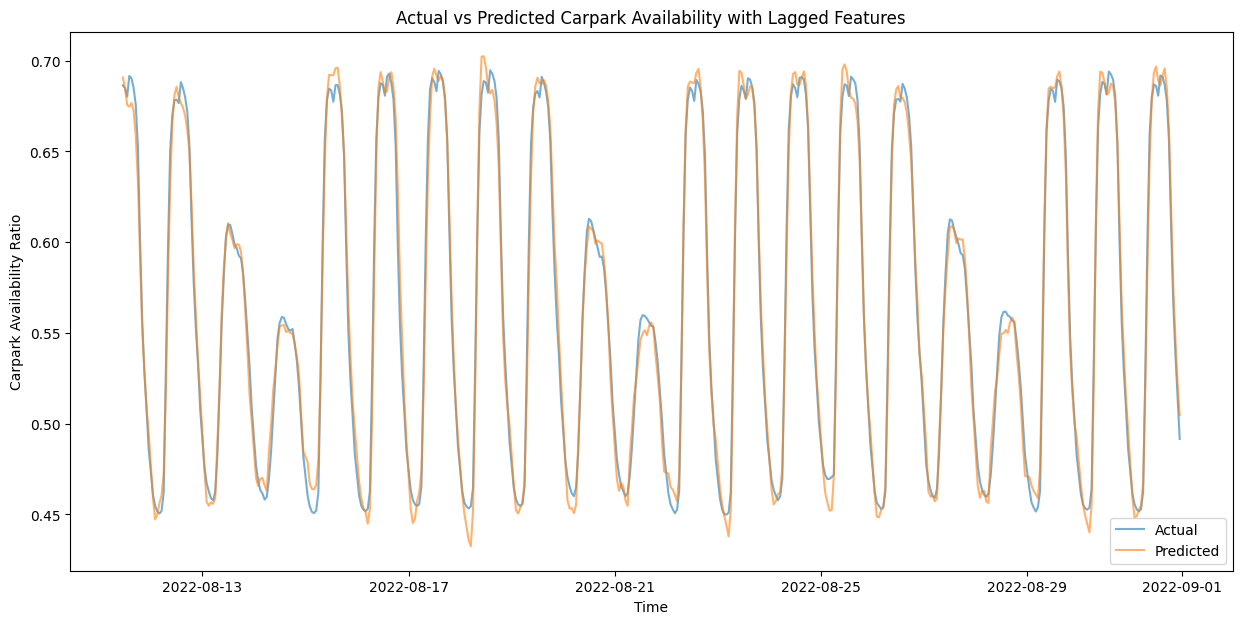

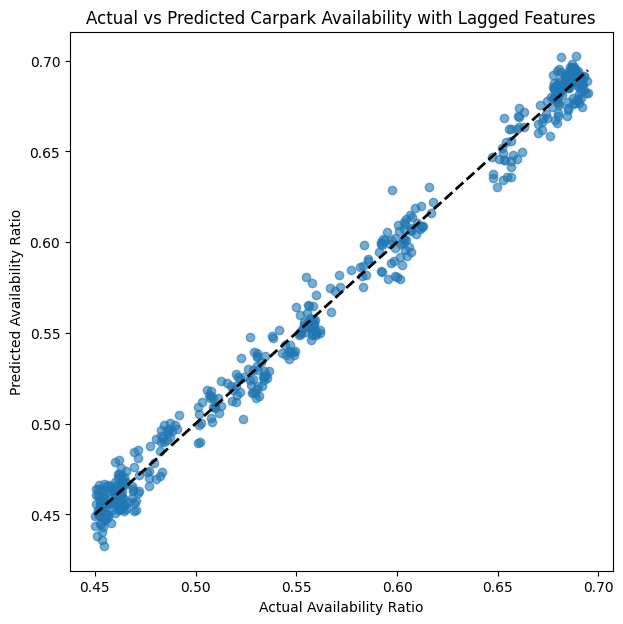

In [ ]:
# Question 2.3: SVR Forecast

# Train the model.
# model = SVR()
model = SVR(kernel="linear", C=100, gamma=0.1, epsilon=0.01) # Hyper-parameter Tuning.
model.fit(X_train, y_train)

# Evaluate the Model.
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Calculate metrics.
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)

# Perform 5-fold cross-validation to test for overfitting.
k = 5
scores_svr = cross_val_score(model, X_train, y_train, cv=k, scoring='r2')
mean_scores_svr = scores_svr.mean()
std_scores_svr = scores_svr.std()

print('Regression Metrics:')
print(f'[Train] MSE: {mse_train}, R2: {r2_train}')
print(f"[Cross Validation on Train] Mean R2 = {mean_scores_svr:.4f}, Std = {std_scores_svr:.4f}")
print(f'[Test] MSE: {mse_test}, R2: {r2_test}')
print('======================================================================')

# Visualization.
# (i) Time series plot of the actual and predicted hourly values.
plt.figure(figsize=(15, 7))
plt.plot(df_test.index, y_test, label='Actual', alpha=0.6)
plt.plot(df_test.index, predictions_test, label='Predicted', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Carpark Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.legend()
plt.show()

# (ii) Scatter plot of actual vs predicted hourly values.
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions_test, alpha=0.6)
plt.xlabel('Actual Availability Ratio')
plt.ylabel('Predicted Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()



---



# **Question 2.4: Decision Tree Regressor (DT) Forecast**
> Question: Do the same as Question 2.2 above but use decision tree (DT) regressor.

## Question 2.4 Code

Regression Metrics:
[Train] MSE: 5.641768286275281e-07, R2: 0.9999206944674583
[Cross Validation on Train] Mean R2 = 0.9266, Std = 0.1048
[Test] MSE: 0.00011682712802425333, R2: 0.9847265742830696


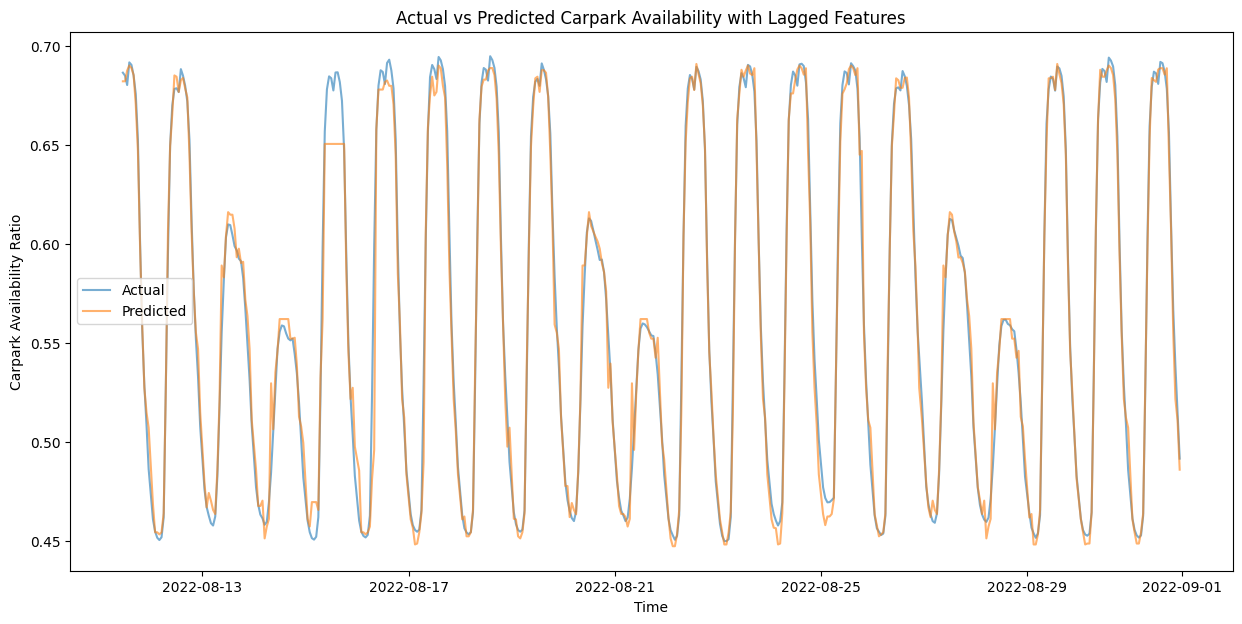

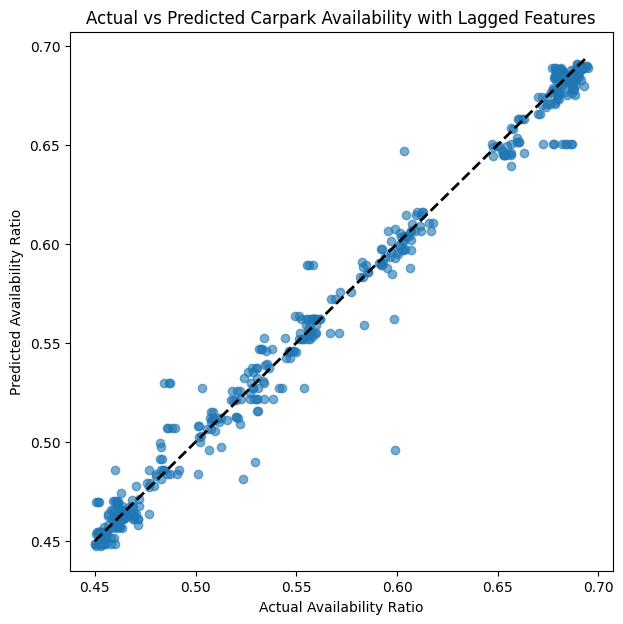

In [ ]:
# Question 2.4: DTR Forecast

# Train the model.
# model = DecisionTreeRegressor()
model = DecisionTreeRegressor(random_state=0,max_depth=10,min_samples_split=2) # Hyper-parameter Tuning.
model.fit(X_train, y_train)

# Evaluate the Model.
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Calculate metrics.
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)

# Perform 5-fold cross-validation to test for overfitting.
k = 5
scores_dt = cross_val_score(model, X_train, y_train, cv=k, scoring='r2')
mean_scores_dt = scores_dt.mean()
std_scores_dt = scores_dt.std()

print('Regression Metrics:')
print(f'[Train] MSE: {mse_train}, R2: {r2_train}')
print(f"[Cross Validation on Train] Mean R2 = {mean_scores_dt:.4f}, Std = {std_scores_dt:.4f}")
print(f'[Test] MSE: {mse_test}, R2: {r2_test}')
print('======================================================================')

# Visualization.
# (i) Time series plot of the actual and predicted hourly values.
plt.figure(figsize=(15, 7))
plt.plot(df_test.index, y_test, label='Actual', alpha=0.6)
plt.plot(df_test.index, predictions_test, label='Predicted', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Carpark Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.legend()
plt.show()

# (ii) Scatter plot of actual vs predicted hourly values.
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions_test, alpha=0.6)
plt.xlabel('Actual Availability Ratio')
plt.ylabel('Predicted Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()



---



# **Question 2.5: Recommendation & Hyper-parameter Tuning**
> Question:  Make a final recommendation for the best regression model (out of the 3 methods above)
by choosing a suitable performance metric. To ensure a fair comparison, carry out hyper-parameter tuning for all 3 methods. Then, make a final recommendation selecting only
one model. Include both quantitative and qualitative arguments for your choice.


## Question 2.5 Answer:

>R-Squared Values before Hyper-Parameter Tuning:
- Linear Regression:
  - [Train] R2: 0.9990928009359937
  - [Cross Validation on Train] Mean R2 = 0.9945, Std = 0.0045
  - [Test] R2: 0.9975614015889941
- Support Vector Regression (SVR):
  - [Train] R2: 0.2928802094861652
  - [Cross Validation on Train] Mean R2 = 0.2792, Std = 0.0249
  - [Test] R2: 0.299800253449939
- Decision Tree (DTR) Regression:
  - [Train] R2: 1.0
  - [Cross Validation on Train] Mean R2 = 0.9201, Std = 0.1002
  - [Test] R2: 0.9760959245524419

>R-Squared Values after Hyper-Parameter Tuning:
- Linear Regression:
  - [Train] R2: 0.9990928009359937
  - [Cross Validation on Train] Mean R2 = 0.9945, Std = 0.0045
  - [Test] R2: 0.9975614015889941
- Support Vector Regression (SVR):
  - [Train] R2: 0.9934154362513555
  - [Cross Validation on Train] Mean R2 = 0.9803, Std = 0.0088
  - [Test] R2: 0.99031361299258
- Decision Tree (DTR) Regression:
  - [Train] R2: 0.9999206944674583
  - [Cross Validation on Train] Mean R2 = 0.9266, Std = 0.1048
  - [Test] R2: 0.9847265742830696

### Best Regression Model after Hyper-Parameter Tuning:
#### Quantitative Analysis:
- Linear Regression:
  - sklearn.linear_model.LinearRegression(*, fit_intercept=True, copy_X=True, n_jobs=None, positive=False).
  - When checking the documentation for LinearRegression(), we found that there were no variables that we can change and, if we were to add regularization to the model we would need to use Ridge regression.
  - It has an excellent R2 score on both training and test datasets, which means the model explains most of the variability of the response data around its mean.

- Support Vector Regression (SVR):
  - SVR showed a significant improvement after hyper-parameter tuning by changing the values of epsilon and C, with the R2 score on the training set jumping from 0.2929 to 0.9934 and on the test set from 0.2998 to 0.9903. We did this by decreasing epsilon which will make the model more strict in fitting the points.
  - The standard deviation of the R2 score during cross-validation is low, indicating that the model has good stability across different subsets of the data.

- Decision Tree Regression (DTR):
  - The decision tree regressor also showed high performance, but it seems to be slightly overfitting the data given the perfect R2 score on the training set before tuning and almost perfect after tuning. To combat the overfitting we set a hard limit for the max depth of the tree to prevent a very deep, branched out tree which will definitely result in overfitting.
  - After hyper-parameter tuning, the model's performance on the test set improved, and the mean cross-validation R2 score increased slightly.

#### Qualitative Arguments:
- Linear Regression:
  - It is a simple model with high interpretability.
  - Good for understanding the relationship between input and output variables but may not capture complex patterns.

- Support Vector Regression (SVR):
  - SVR is more flexible in finding a non-linear decision boundary.
  - The dramatic improvement after hyper-parameter tuning suggests that SVR sensitive to hyperparameters and can be greatly optimized.
  - Given the excellent R2 scores after tuning, it appears to generalize very well.

- Decision Tree Regression (DTR):
  - Decision trees can capture complex non-linear relationships and interactions between variables.
  - Prone to overfitting, but hyper-parameter tuning can mitigate this to some extent.
  - It has high interpretability, but as trees become deeper i.e. more splits, they can become more difficult to interpret.

#### Final Recommendation:
Based on the metrics, **Support Vector Regression (SVR)** would be the recommended model.

- Significant Improvement from Tuning: SVR benefited the most from hyper-parameter tuning, suggesting that further optimization could yield even better results.
- High Generalization Capability: After tuning, SVR demonstrated an excellent ability to generalize with a high R2 score on the test set.
- Stability: The cross-validation results indicate that the model is stable across different subsets of the training data.
- Flexibility: SVR is suitable for both linear and non-linear relationships, which makes it a versatile model for various types of datasets.

While the linear regression model also showed high performance, it does not have much tuning that we can apply.

On the other hand, the decision tree, while slightly overfitting, might not be as robust as SVR when dealing with new data, given the lower (though still good) R2 score on the test set and higher variability in cross-validation scores.

Hence, this is why we have chosen SVR as the recommended model.



---



# Question 3: Group Proposed Project

**Project Proposal: Carpark Fullness Prediction Near Food Places**

Our team will explore advanced methods of Machine Learning to deal with the carpark availability data and make it useful for users by predicting carpark fullness near hawker centres in Singapore.

We will be testing methods such as Ensembling and Boosting to make a robust prediction model.

To increase stability and reduce variability in our models, we will use 5 months of training data (Jul 2022 - Nov 2022) and 1 month for our test data (Dec 2022).



## Question 3 Code

### Import Packages

In [ ]:
# Imports for Question 3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# Set a seed for reproducibility
seed = 4204
np.random.seed(seed)

# Ensembling
from sklearn.ensemble import StackingRegressor

# Support Vector Regression
from sklearn.svm import SVR

# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

# Random Forest
from sklearn.ensemble import RandomForestRegressor

# AdaBoost
from sklearn.ensemble import AdaBoostRegressor

# Regression Metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

### Part 1: Find The Best Model to Use for our Data

We will be exploring different types of Ensembling, namely Bagging and Boosting, in this section to determine which model would be suitable for our predictions.

In [ ]:
# Get training and test datasets
# Check for JSON file. If it does not exist, create it.

# Parameters for API Call.
start_months = ['7', '8', '9', '10', '11', '12']
num_months = 1
minute_interval = 60

for start_month in start_months:
  # Write into filesystem as we can reuse in future questions and is also a long process to get the data.
  path = f"{shared_path}/ee4211_data_{start_month}_{num_months}_{minute_interval}.json"

  # If file does not exist, call API and create one.
  if (not os.path.exists(path)):
    print(f"Creating json starting at month {start_month} for {num_months} month at {minute_interval} min intervals.")
    json = get_json(start_month, num_months, minute_interval)
    if json == None:
      raise Exception("Creating json failed.")
  else:
    print(f'JSON at path ({path}) present.')

JSON at path (/content/drive/My Drive/EE4211_proj_copy/ee4211_data_7_1_60.json) present.
JSON at path (/content/drive/My Drive/EE4211_proj_copy/ee4211_data_8_1_60.json) present.
JSON at path (/content/drive/My Drive/EE4211_proj_copy/ee4211_data_9_1_60.json) present.
JSON at path (/content/drive/My Drive/EE4211_proj_copy/ee4211_data_10_1_60.json) present.
JSON at path (/content/drive/My Drive/EE4211_proj_copy/ee4211_data_11_1_60.json) present.
JSON at path (/content/drive/My Drive/EE4211_proj_copy/ee4211_data_12_1_60.json) present.


#### 1.1 Load Data
Obtain Training Data: Jul 2022 to Nov 2022

Obtain Test Data: Dec 2022

In [ ]:
def process_parking_data(df_load):
  data_points = []

  for timestamp in range(df_load.shape[0]):
    data = df_load[0][timestamp]['carpark_data']
    # Convert list to dataframe.
    df = pd.DataFrame(data)

    for heading in ("total_lots","lot_type","lots_available"):
        df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
    df = df.drop(["carpark_info"], axis=1)
    # Data clean on df.
    df.dropna(inplace = True)

    total_lots_sum = 0
    lots_available_sum = 0

    for i in range(1, len(df['total_lots'])):
      lots_available_sum += int(df['lots_available'][i])
      total_lots_sum += int(df['total_lots'][i])

    # Calculate the ratio.
    ratio = lots_available_sum / total_lots_sum

    # Save the data points.
    time = df_load[0][timestamp]['timestamp']
    data_points.append((time, ratio))

  # Parse the timestamp and ratio into separate lists.
  dates, times, ratios = [], [], []
  for timestamp, ratio in data_points:
      # Parse the timestamp with dateutil's parse function.
      dt = parse(timestamp)
      # Extract date and time
      dates.append(dt.strftime('%Y-%m-%d'))
      times.append(dt.strftime('%H:%M'))
      ratios.append(ratio)

  # Create a DataFrame.
  df = pd.DataFrame({
      'date': dates,
      'time': times,
      'ratio': ratios
  })

  return df

In [ ]:
# Load Training Data
# Jul 2022 - Nov 2022
df_data_jul = pd.read_json(f'{shared_path}/ee4211_data_7_1_60.json')
df_data_aug = pd.read_json(f'{shared_path}/ee4211_data_8_1_60.json')
df_data_sep = pd.read_json(f'{shared_path}/ee4211_data_9_1_60.json')
df_data_oct = pd.read_json(f'{shared_path}/ee4211_data_10_1_60.json')
df_data_nov = pd.read_json(f'{shared_path}/ee4211_data_11_1_60.json')

# Load Test Data
# December 2022
df_test_dec = pd.read_json(f'{shared_path}/ee4211_data_12_1_60.json')

In [ ]:
#Get datasets
df_train_models = pd.concat([df_data_jul, df_data_aug, df_data_sep, df_data_oct, df_data_nov], ignore_index = True)
df_train_models = process_parking_data(df_train_models)
df_test_models = process_parking_data(df_test_dec)

df_train_models

date   time     ratio
0     2022-07-01  00:59  0.465898
1     2022-07-01  02:00  0.458253
2     2022-07-01  03:00  0.455494
3     2022-07-01  04:00  0.457910
4     2022-07-01  05:00  0.458170
...          ...    ...       ...
3514  2022-11-30  19:00  0.604489
3515  2022-11-30  20:00  0.561720
3516  2022-11-30  21:00  0.533799
3517  2022-11-30  22:00  0.511329
3518  2022-11-30  23:00  0.488856

[3519 rows x 3 columns]

In [ ]:
# Function to create lagged features.
def create_lagged_features(df, n_lags):
    lagged_dfs = [df]  # Start with the original DataFrame in a list.
    for n in range(1, n_lags + 1):
        lagged_df = df[['ratio']].shift(n)  # Create a DataFrame of shifted values.
        lagged_df.rename(columns={'ratio': f'lag_{n}h'}, inplace=True)  # Rename the shifted column.
        lagged_dfs.append(lagged_df)  # Add the new DataFrame to the list.

    # Concatenate all the DataFrames in the list.
    df_with_lags = pd.concat(lagged_dfs, axis=1)
    return df_with_lags

In [ ]:
# Merge the date and time columns and convert to datetime.
df_train_models['datetime'] = pd.to_datetime(df_train_models['date'] + ' ' + df_train_models['time'])
df_test_models['datetime'] = pd.to_datetime(df_test_models['date'] + ' ' + df_test_models['time'])

# Set the datetime as the index.
df_train_models = df_train_models.set_index('datetime')
df_test_models = df_test_models.set_index('datetime')

# Create lagged features for the last 10 days.
n_lags = 10 * 24
df_train_models = create_lagged_features(df_train_models, n_lags)
df_test_models = create_lagged_features(df_test_models, n_lags)

# Drop rows with NaN values that were created by shifting.
df_train_models.dropna(inplace=True)
df_test_models.dropna(inplace=True)

# The new feature matrix includes the lagged features plus the hour and day of week.
df_train_models['hour'] = df_train_models.index.hour
df_train_models['day_of_week'] = df_train_models.index.dayofweek
df_test_models['hour'] = df_test_models.index.hour
df_test_models['day_of_week'] = df_test_models.index.dayofweek

X_train = df_train_models.drop(['date', 'time', 'ratio'], axis=1)
y_train = df_train_models['ratio']

X_test = df_test_models.drop(['date', 'time', 'ratio'], axis=1)
y_test = df_test_models['ratio']

#### 1.2 Random Forest Ensemble

Regression Metrics:
[Train] MSE: 6.402233720249221e-06, R2: 0.9990821988204088
[Cross Validation on Train] Mean R2 = 0.9948, Std = 0.0021
[Test] MSE: 7.641169090923836e-05, R2: 0.9859575621806412


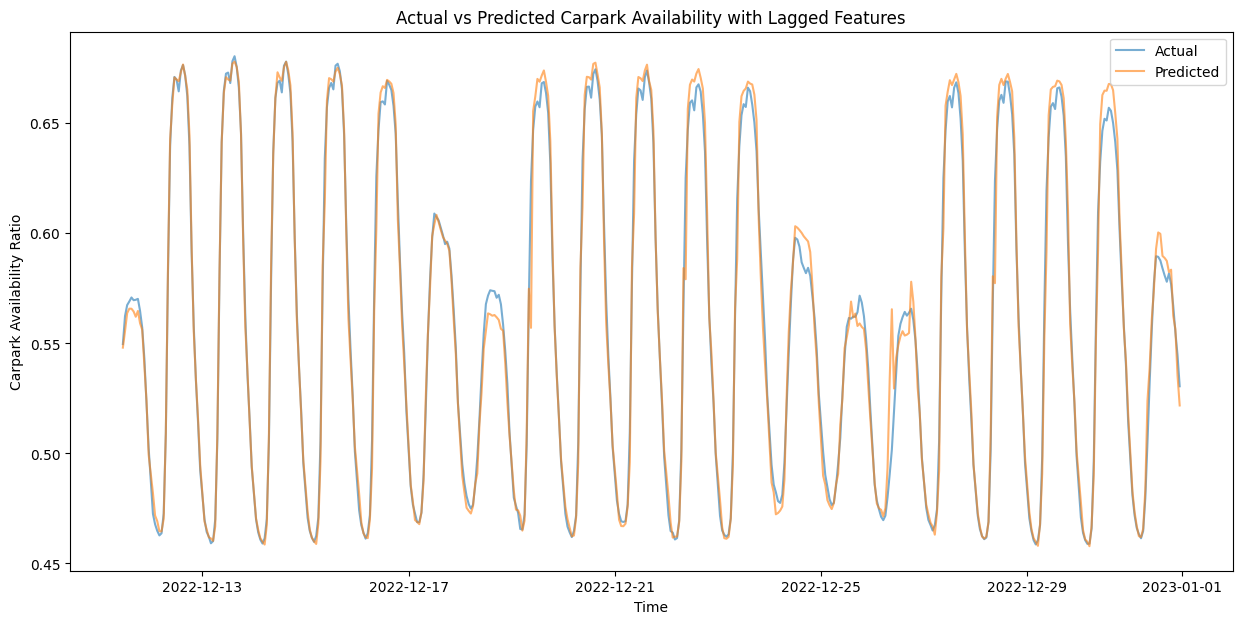

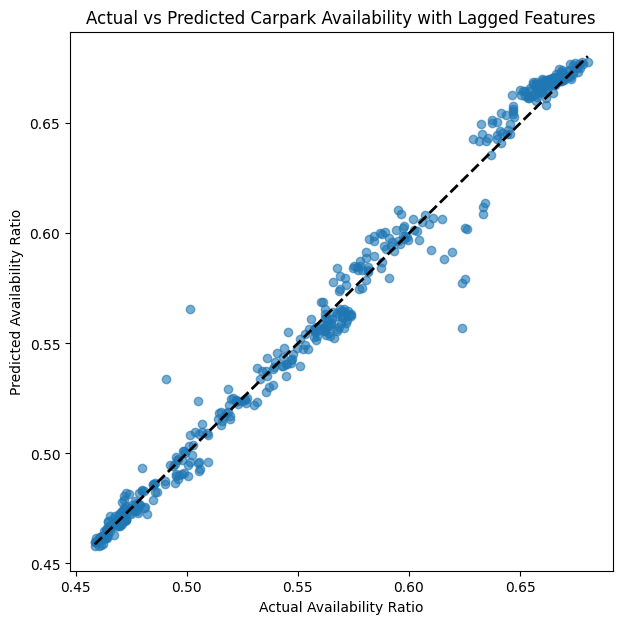

In [ ]:
# Random Forest Forecast

# Train the model.
model = RandomForestRegressor(n_estimators=50, max_depth=10) # Hyper-parameter Tuning.
model.fit(X_train, y_train)

# Evaluate the Model.
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Calculate metrics.
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)

# Perform 5-fold cross-validation to test for overfitting.
k = 5
scores_dt = cross_val_score(model, X_train, y_train, cv=k, scoring='r2')
mean_scores_dt = scores_dt.mean()
std_scores_dt = scores_dt.std()

print('Regression Metrics:')
print(f'[Train] MSE: {mse_train}, R2: {r2_train}')
print(f"[Cross Validation on Train] Mean R2 = {mean_scores_dt:.4f}, Std = {std_scores_dt:.4f}")
print(f'[Test] MSE: {mse_test}, R2: {r2_test}')
print('======================================================================')

# Visualization.
# (i) Time series plot of the actual and predicted hourly values.
plt.figure(figsize=(15, 7))
plt.plot(X_test.index, y_test, label='Actual', alpha=0.6)
plt.plot(X_test.index, predictions_test, label='Predicted', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Carpark Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.legend()
plt.show()

# (ii) Scatter plot of actual vs predicted hourly values.
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions_test, alpha=0.6)
plt.xlabel('Actual Availability Ratio')
plt.ylabel('Predicted Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

#### 1.3 Decision Tree and SVR Ensemble

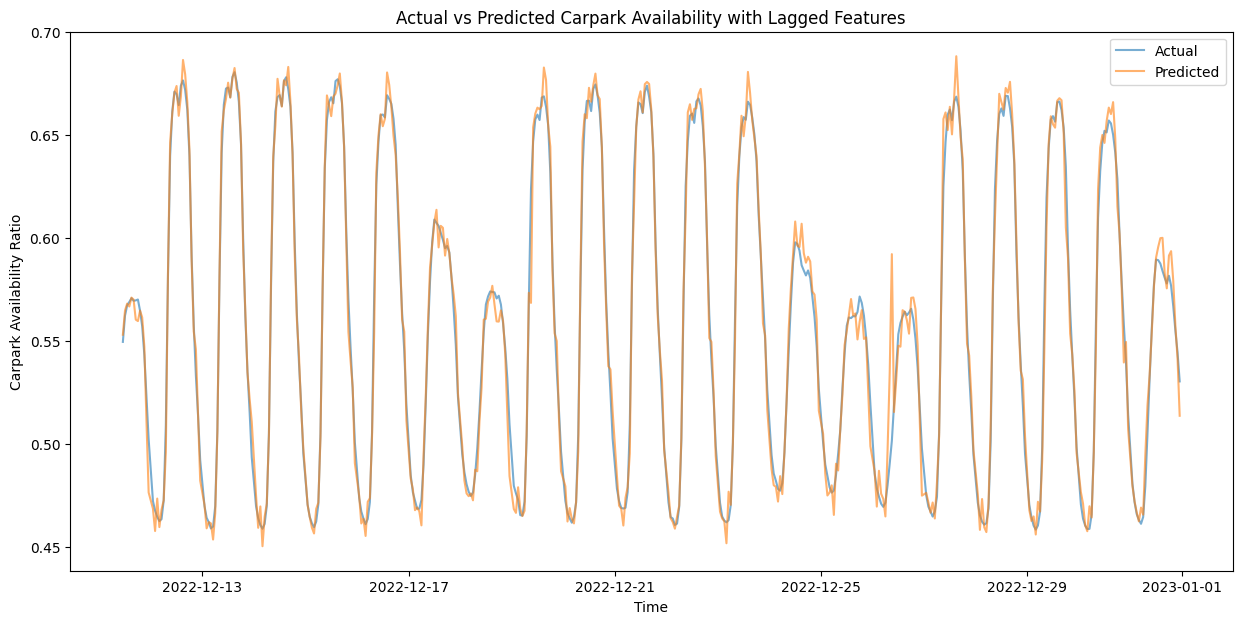

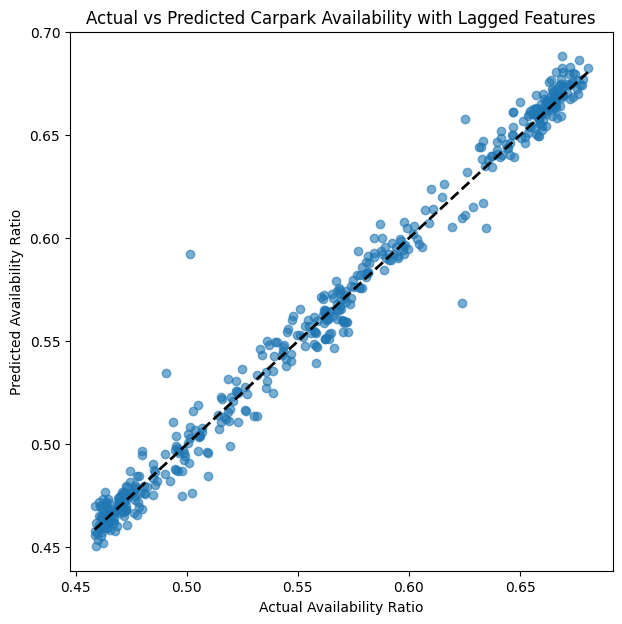

In [ ]:
# Decision Tree and SVR Forecast
# Ensembling better visualised

# Train the models.
# 1 SVR and 1 DT Regressor for the ensemble
dtr = DecisionTreeRegressor(random_state=0,max_depth=10,min_samples_split=2) # Hyper-parameter Tuning.
dtr.fit(X_train, y_train)
svr = SVR(kernel="linear", C=100, gamma=0.1, epsilon=0.01) # Hyper-parameter Tuning.
svr.fit(X_train, y_train)

# Evaluate the Model.
predictions_train_dtr = dtr.predict(X_train)
predictions_train_svr = svr.predict(X_train)
predictions_train = np.round((predictions_train_dtr + predictions_train_svr) / 2, decimals=6)

predictions_test_dtr = dtr.predict(X_test)
predictions_test_svr = svr.predict(X_test)
predictions_test = np.round((predictions_test_dtr + predictions_test_svr) / 2, decimals=6)

# Calculate metrics.
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)

# Perform 5-fold cross-validation to test for overfitting. (We need a estimator object (something with a fit function))
# k = 5
# scores_dt = cross_val_score(model, X_train, y_train, cv=k, scoring='r2')
# mean_scores_dt = scores_dt.mean()
# std_scores_dt = scores_dt.std()

# print('Regression Metrics:')
# print(f'[Train] MSE: {mse_train}, R2: {r2_train}')
# print(f"[Cross Validation on Train] Mean R2 = {mean_scores_dt:.4f}, Std = {std_scores_dt:.4f}")
# print(f'[Test] MSE: {mse_test}, R2: {r2_test}')
# print('======================================================================')

# Visualization.
# (i) Time series plot of the actual and predicted hourly values.
plt.figure(figsize=(15, 7))
plt.plot(X_test.index, y_test, label='Actual', alpha=0.6)
plt.plot(X_test.index, predictions_test, label='Predicted', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Carpark Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.legend()
plt.show()

# (ii) Scatter plot of actual vs predicted hourly values.
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions_test, alpha=0.6)
plt.xlabel('Actual Availability Ratio')
plt.ylabel('Predicted Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

#### 1.4 AdaBoostRegressor on Decision Tree


Regression Metrics:
[Train] MSE: 3.4627357917446028e-06, R2: 0.9995035946619343
[Cross Validation on Train] Mean R2 = 0.9962, Std = 0.0016
[Test] MSE: 7.448248091016245e-05, R2: 0.9863120997014073


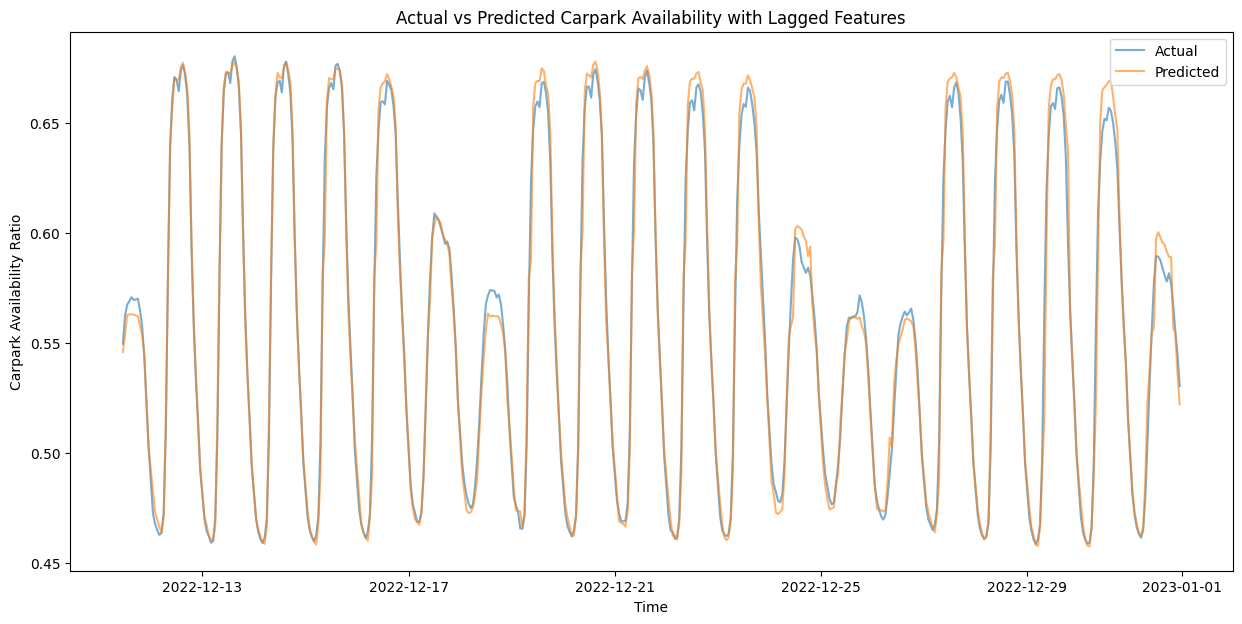

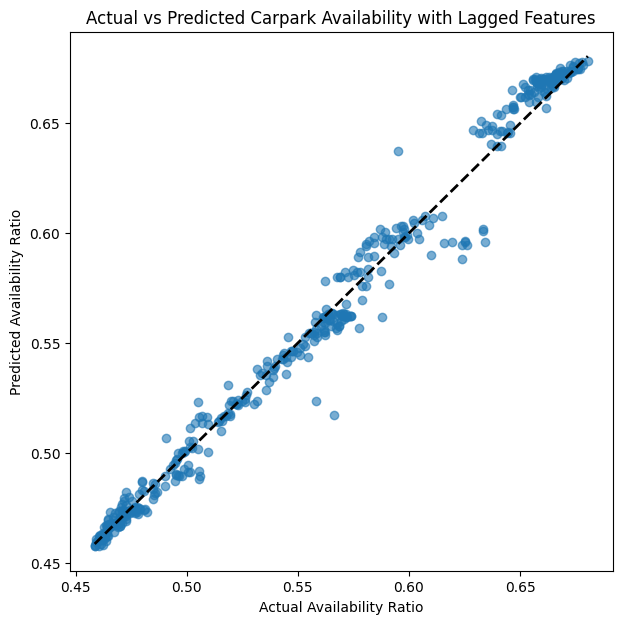

In [ ]:
# AdaBoost on DecisionTreeRegressor

# Train the model.
# Create a Decision Tree (DT) model as the 'weak' model (drop the max depth as the initial model is supposed to be not that good yes?)
# Conduct AdaBoost on DT
weak_model = DecisionTreeRegressor(random_state=0,max_depth=8,min_samples_split=2) # Hyper-parameter Tuning.
model = AdaBoostRegressor(weak_model, n_estimators=50, random_state=0)
model.fit(X_train, y_train)

# Evaluate the Model.
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Calculate metrics.
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)

# Perform 5-fold cross-validation to test for overfitting.
k = 5
scores_dt = cross_val_score(model, X_train, y_train, cv=k, scoring='r2')
mean_scores_dt = scores_dt.mean()
std_scores_dt = scores_dt.std()

print('Regression Metrics:')
print(f'[Train] MSE: {mse_train}, R2: {r2_train}')
print(f"[Cross Validation on Train] Mean R2 = {mean_scores_dt:.4f}, Std = {std_scores_dt:.4f}")
print(f'[Test] MSE: {mse_test}, R2: {r2_test}')
print('======================================================================')

# Visualization.
# (i) Time series plot of the actual and predicted hourly values.
plt.figure(figsize=(15, 7))
plt.plot(X_test.index, y_test, label='Actual', alpha=0.6)
plt.plot(X_test.index, predictions_test, label='Predicted', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Carpark Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.legend()
plt.show()

# (ii) Scatter plot of actual vs predicted hourly values.
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions_test, alpha=0.6)
plt.xlabel('Actual Availability Ratio')
plt.ylabel('Predicted Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

#### 1.5 AdaBoostRegressor on SVR

In [ ]:
# AdaBoost on SupportVectorRegressor

# Train the model.
# Create a SVR model as the 'weak' model
# Conduct AdaBoost on SVR
weak_model = SVR(kernel="linear", C=100, gamma=0.1, epsilon=0.01) # Hyper-parameter Tuning.
model = AdaBoostRegressor(weak_model, n_estimators=2, random_state=0)
model.fit(X_train, y_train)

# Evaluate the Model.
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Calculate metrics.
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)

# # Perform 5-fold cross-validation to test for overfitting.
# k = 5
# scores_dt = cross_val_score(model, X_train, y_train, cv=k, scoring='r2')
# mean_scores_dt = scores_dt.mean()
# std_scores_dt = scores_dt.std()

# print('Regression Metrics:')
# print(f'[Train] MSE: {mse_train}, R2: {r2_train}')
# print(f"[Cross Validation on Train] Mean R2 = {mean_scores_dt:.4f}, Std = {std_scores_dt:.4f}")
# print(f'[Test] MSE: {mse_test}, R2: {r2_test}')
# print('======================================================================')



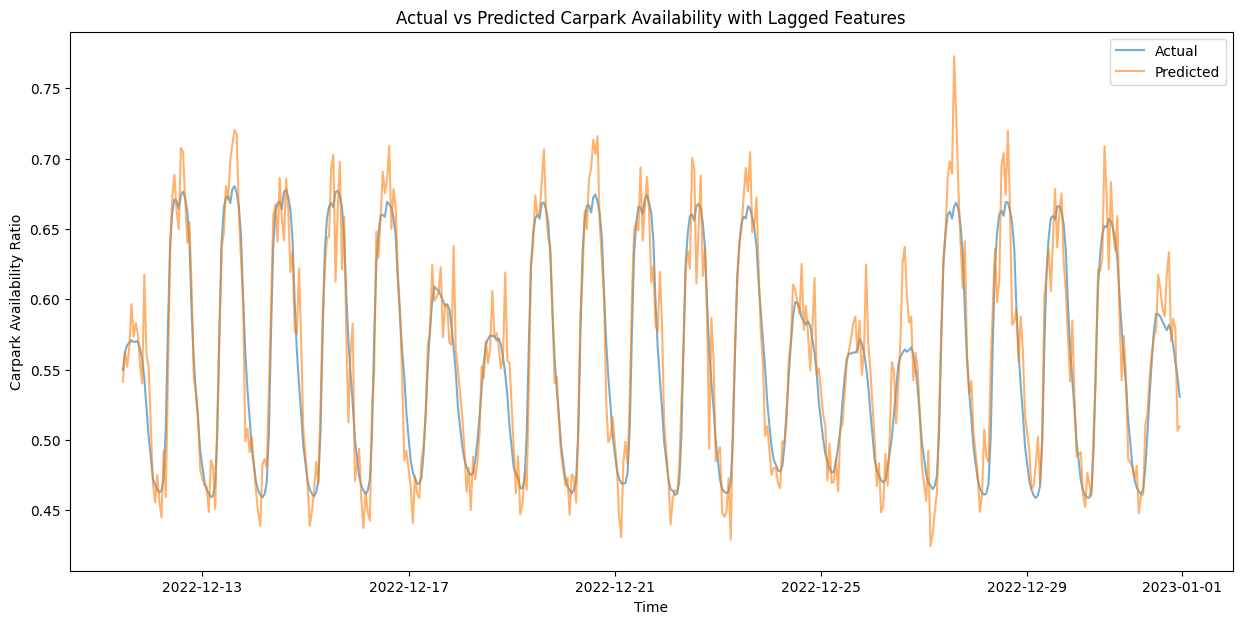

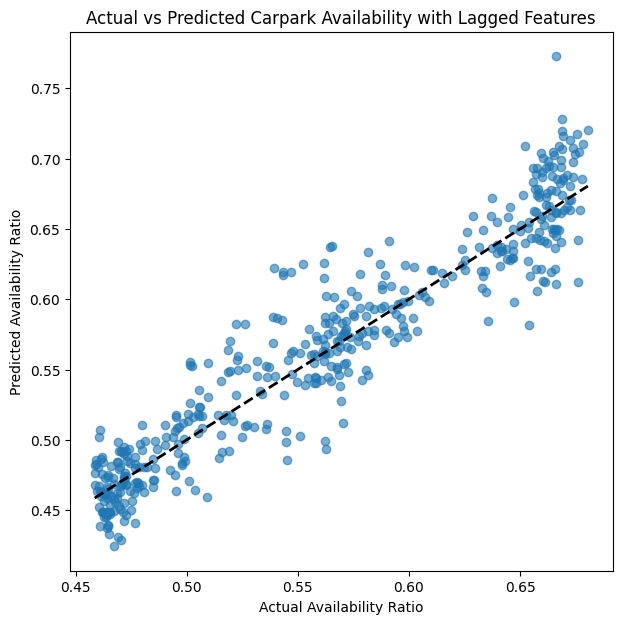

In [ ]:
# Visualization.
# (i) Time series plot of the actual and predicted hourly values.
plt.figure(figsize=(15, 7))
plt.plot(X_test.index, y_test, label='Actual', alpha=0.6)
plt.plot(X_test.index, predictions_test, label='Predicted', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Carpark Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.legend()
plt.show()

# (ii) Scatter plot of actual vs predicted hourly values.
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions_test, alpha=0.6)
plt.xlabel('Actual Availability Ratio')
plt.ylabel('Predicted Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

#### 1.6 Model Decision (NOT DONE)

The model that was chosen was the random forest.

### Part 2: Get Carparks Near Hawker Centres Data
Using data we collected on Carpark Location and Hawker Centres near them (*nearby.json*), we will check for carparks that are in the original dataset that are near Hawker Centres and store them in a JSON file.

In [ ]:
import math
import json
import os

def haversine(coord1, coord2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Coordinates in decimal degrees (e.g. 43.60, -79.49)
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    # Convert latitude and longitude from degrees to radians
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    # Haversine formula
    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c

    return distance


tolerance = 0.4
nearby = []

if(not os.path.exists(f"{shared_path}/nearby.json")):

  with open(f"{shared_path}/carpark.json", "r") as file:
      carpark_json = json.load(file)

  with open(f"{shared_path}/HawkerCentreData_formatted.json", "r") as file:
      hawker_center_json = json.load(file)

  carparks = carpark_json["value"]
  for hawker_center in hawker_center_json:
      name = hawker_center["hawker_name"]
      hawker_location = hawker_center["coordinates"]
      locs = hawker_location.split(" ")
      coord1 = (float(locs[0]), float(locs[1]))
      # print(coord1)
      for carpark in carparks:

          carparkId = carpark["CarParkID"]
          carpark_location = carpark["Location"]
          carpark_name = carpark["Development"]
          locs2 = carpark_location.split(" ")
          coord2 = (float(locs2[0]), float(locs2[1]))
          # print(coord2)

          distance = haversine(coord1, coord2)
          is_1_km_apart = abs(distance - 0.2) < tolerance  # tolerance could be a small value like 10 to allow for some margin
          if (is_1_km_apart):
              nearby.append({"Id" : carparkId, "carpark": carpark_name , "location" : carpark_location, "hawker": name, "distance": distance})
          # print(f"{carparkId} is nearby {name} with dist {distance}")

  with open(f"{shared_path}/nearby.json", "r") as file:
      json.dump(nearby, file, indent=4)

else:
  print("Json for nearby carparks has been generated before")

Json for nearby carparks has been generated before


In [ ]:
df_nearby_data = pd.read_json(f"{shared_path}/nearby.json")
df_jul_data = pd.read_json(f'{shared_path}/ee4211_data_7_1_60.json')

In [ ]:
hawker_nearby_fp = f'{shared_path}/hawker_nearby.json'

if os.path.isfile(hawker_nearby_fp):
  print(f'Existing hawker_nearby.json file found at {hawker_nearby_fp}')
else:
  hawker_dict = {}
  for carpark in df_jul_data.iloc[0][0]["carpark_data"]:
    id = carpark['carpark_number']
    if id in df_nearby_data['Id'].unique():
      hawker_name = df_nearby_data[df_nearby_data['Id'] == id]['hawker'].iloc[0]
      carpark_add = df_nearby_data[df_nearby_data['Id'] == id]['carpark'].iloc[0]
      carpark_coord = df_nearby_data[df_nearby_data['Id'] == id]['location'].iloc[0] #Carpark coord
      data = {
          'carpark_id': id,
          'carpark_add': carpark_add,
          'carpark_coord': carpark_coord
      }
      if hawker_dict.get(hawker_name, 0):
        hawker_dict[hawker_name].append(data)
      else:
        hawker_dict[hawker_name] = [data]
  print(hawker_dict)
  with open(hawker_nearby_fp, 'w') as f:
    json.dump(hawker_dict, f, indent=4)

Existing hawker_nearby.json file found at /content/drive/My Drive/EE4211_proj_copy/hawker_nearby.json


#### 2.1 Selecting Carparks

Based on the data generated from the code above (in *hawker_nearby.json*), we will be using the following data collected as our proof of concept:

```
"Yishun Ring Road Blk 104/105 (Chong Pang Market and Food Centre)":
[
        {
            "carpark_id": "Y8",
            "carpark_add": "BLK 731/746 YISHUN STREET 71,72/AVENUE 5",
            "carpark_coord": "1.4294449190702871 103.83127807040323"
        },
        {
            "carpark_id": "Y3",
            "carpark_add": "BLK 112/120 YISHUN RING ROAD",
            "carpark_coord": "1.4347114221949966 103.82888652134125"
        },
        {
            "carpark_id": "Y3M",
            "carpark_add": "BLK 115A/115B/115C YISHUN RING ROAD",
            "carpark_coord": "1.4335446820824216 103.82746981634773"
        },
        {
            "carpark_id": "Y4",
            "carpark_add": "BLK 121/143 YISHUN STREET 11/RING ROAD",
            "carpark_coord": "1.4347516057906717 103.83150986637463"
        },
        {
            "carpark_id": "Y7",
            "carpark_add": "BLK 701/716 & 701B YISHUN AVENUE 5",
            "carpark_coord": "1.4273018179334416 103.82745054301381"
        },
        {
            "carpark_id": "Y5",
            "carpark_add": "BLK 144/149 YISHUN STREET 11",
            "carpark_coord": "1.4311145317313538 103.83210758322952"
        },
        {
            "carpark_id": "Y58",
            "carpark_add": "162 YISHUN STREET 11",
            "carpark_coord": "1.432539248516593 103.83238250558868"
        },
        {
            "carpark_id": "Y1",
            "carpark_add": "BLK 101/102 YISHUN AVE 5",
            "carpark_coord": "1.4308445425594365 103.82803573858493"
        },
        {
            "carpark_id": "Y2",
            "carpark_add": "BLK 103/111 YISHUN RING ROAD",
            "carpark_coord": "1.4321665542852815 103.82805888962517"
        }
]
```



### Part 3: Extract 4 Months of Data for a Particular Carpark

We will extract the relevant data for a particular carpark from the 4 months of data that we got from our API calls on carpark availability.

#### 3.1: Load Data

In [ ]:
df_train = pd.concat([df_data_jul, df_data_aug, df_data_sep, df_data_oct, df_data_nov], ignore_index = True)
df_test = df_test_dec

#### 3.2: Extract Data For Particular Carpark

In [ ]:
def extract_parking_data(df_load, carpark_name, name="default"):
  filepath = f"{shared_path}/parking_{carpark_name}_{name}.json"

  if os.path.exists(filepath):
    print(f"File at path ({filepath}) already exists, loading from file.")
    df = pd.read_json(filepath)
    return df

  data_points = []

  for timestamp in range(df_load.shape[0]):
    data = df_load[0][timestamp]['carpark_data']
    # Convert list to dataframe.
    df = pd.DataFrame(data)

    for heading in ("total_lots","lot_type","lots_available"):
      for carpark in df_load[0][timestamp]['carpark_data']:
        if carpark["carpark_number"] == carpark_name:
          # Calculate the ratio.
          ratio = float(carpark["carpark_info"][0]['lots_available']) / float(carpark["carpark_info"][0]['total_lots'])
          df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
    df = df.drop(["carpark_info"], axis=1)
    # Data clean on df.
    df.dropna(inplace = True)

    # Total Calculation
    total_lots_sum = 0
    lots_available_sum = 0

    if 'total_lots' not in df:
      print(f"{carpark_name} not present")
      return

    # Save the data points.
    time = df_load[0][timestamp]['timestamp']
    data_points.append((time, ratio))

  # Parse the timestamp and ratio into separate lists.
  dates, times, ratios = [], [], []
  for timestamp, ratio in data_points:
      # Parse the timestamp with dateutil's parse function.
      dt = parse(timestamp)
      # Extract date and time
      dates.append(dt.strftime('%Y-%m-%d'))
      times.append(dt.strftime('%H:%M'))
      ratios.append(ratio)

  # Create a DataFrame.
  df = pd.DataFrame({
      'date': dates,
      'time': times,
      'ratio': ratios
  })


  df.to_json(filepath)

  return df

### Part 4: Generate Training Set from Extracted Data
We will now generate the train and test sets from the extracted data which we can use for our prediction model.

In [ ]:
def gen_sets(dataframe_train, dataframe_test):
  dataframe_train['date'] = dataframe_train['date'].astype(str)
  dataframe_train['time'] = dataframe_train['time'].astype(str)
  dataframe_test['date'] = dataframe_test['date'].astype(str)
  dataframe_test['time'] = dataframe_test['time'].astype(str)

  # Generate test and train sets for model
  # Merge the date and time columns and convert to datetime.
  dataframe_train['datetime'] = pd.to_datetime(dataframe_train['date'] + ' ' + dataframe_train['time'])
  dataframe_test['datetime'] = pd.to_datetime(dataframe_test['date'] + ' ' + dataframe_test['time'])

  # Set the datetime as the index.
  dataframe_train = dataframe_train.set_index('datetime')
  dataframe_test = dataframe_test.set_index('datetime')

  # Create lagged features for the last 10 days.
  n_lags = 10 * 24
  dataframe_train = create_lagged_features(dataframe_train, n_lags)
  dataframe_test = create_lagged_features(dataframe_test, n_lags)

  # Drop rows with NaN values that were created by shifting.
  dataframe_train.dropna(inplace=True)
  dataframe_test.dropna(inplace=True)

  # The new feature matrix includes the lagged features plus the hour and day of week.
  dataframe_train['hour'] = dataframe_train.index.hour
  dataframe_train['day_of_week'] = dataframe_train.index.dayofweek
  dataframe_test['hour'] = dataframe_test.index.hour
  dataframe_test['day_of_week'] = dataframe_test.index.dayofweek

  X_train = dataframe_train.drop(['date', 'time', 'ratio'], axis=1)
  y_train = dataframe_train['ratio']

  X_test = dataframe_test.drop(['date', 'time', 'ratio'], axis=1)
  y_test = dataframe_test['ratio']

  return (X_train, y_train, X_test, y_test)

# (X_train, y_train, X_test, y_test) = gen_sets(dataframe_train, dataframe_test)

### Part 5: Predict Using Model
Based on the train and test sets, conduct Random Forest Forecasting.

In [ ]:
def RandomForest(X_train, y_train, X_test, y_test):
  # Random Forest Forecast

  # Train the model.
  model = RandomForestRegressor(n_estimators=50, max_depth=5) # Hyper-parameter Tuning.
  model.fit(X_train, y_train)

  # Evaluate the Model.
  predictions_train = model.predict(X_train)
  predictions_test = model.predict(X_test)

  # Calculate metrics.
  mse_train = mean_squared_error(y_train, predictions_train)
  r2_train = r2_score(y_train, predictions_train)
  mse_test = mean_squared_error(y_test, predictions_test)
  r2_test = r2_score(y_test, predictions_test)

  # Perform 5-fold cross-validation to test for overfitting.
  k = 5
  scores_dt = cross_val_score(model, X_train, y_train, cv=k, scoring='r2')
  mean_scores_dt = scores_dt.mean()
  std_scores_dt = scores_dt.std()

  print('Regression Metrics:')
  print(f'[Train] MSE: {mse_train}, R2: {r2_train}')
  print(f"[Cross Validation on Train] Mean R2 = {mean_scores_dt:.4f}, Std = {std_scores_dt:.4f}")
  print(f'[Test] MSE: {mse_test}, R2: {r2_test}')
  print('======================================================================')

  return predictions_test

# pred_test = RandomForest(X_train, y_train, X_test, y_test)

In [ ]:
def visualization(X_test, y_test, pred_test, carpark_name):
  # Visualization.
  # (i) Time series plot of the actual and predicted hourly values.
  plt.figure(figsize=(15, 7))
  plt.plot(X_test.index, y_test, label='Actual', alpha=0.6)
  plt.plot(X_test.index, pred_test, label='Predicted', alpha=0.6)
  plt.xlabel('Time')
  plt.ylabel('Carpark Availability Ratio')
  plt.title(f'Actual vs. Predicted Carpark Availability for {carpark_name}')
  plt.legend()
  plt.show()

  # (ii) Scatter plot of actual vs predicted hourly values.
  plt.figure(figsize=(7, 7))
  plt.scatter(y_test, pred_test, alpha=0.6)
  plt.xlabel('Actual Availability Ratio')
  plt.ylabel('Predicted Availability Ratio')
  plt.title(f'Actual vs. Predicted Carpark Availability for Carpark {carpark_name}')
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
  plt.show()

# visualization(X_test, y_test, pred_test)

### Part 6: Using Predicted Data, Generate 24 Hour Parking Availability for that Carpark

From the predicted data generated by the Random Forest Ensemble model, calculate the 24-hour availability ratios for the particular carpark.

In [ ]:
def gen_availability(pred_test, df_test, carpark_name):
  df_test = df_test.reset_index()  # Reset the index to make 'datetime' a column
  pred_test = pd.DataFrame(pred_test, columns=['predictions'])  # Create a DataFrame for predictions

  # Combine the DataFrames
  df = pd.concat([df_test, pred_test], axis=1)
  df = df.drop(["ratio"], axis=1)
  # Data clean on df.
  df.dropna(inplace = True)

  ratios_list = []
  for index, row in df.iterrows():
    time = str(row['datetime'])
    hour = time[11:13]
    day = time[8:10]
    ratios_list.append((day, hour, row['predictions']))

  # Create New DataFrame to Contain Carpark Hourly Availability Ratios
  df_new = pd.DataFrame(ratios_list, columns=['Day', 'Hour', 'Ratio'])
  df_new['Hour'] = pd.to_numeric(df_new['Hour'], errors='coerce')

  hourly_averages = df_new.groupby(['Hour'])['Ratio'].mean().reset_index()
  hourly_averages['Ratio'] = hourly_averages['Ratio'].apply(lambda x: round(x, 5))

  # Set 'Hour' as the index
  hourly_averages = hourly_averages.set_index('Hour')

  # Reindex to include all hours (0 to 23)
  hourly_averages = hourly_averages.reindex(range(24))

  # Interpolate missing 'Ratio' values and fill any remaining NaNs
  hourly_averages['Ratio'] = hourly_averages['Ratio'].interpolate().ffill().bfill()

  # Reset the index to make 'Hour' a column again
  hourly_averages = hourly_averages.reset_index()

  carpark_data = hourly_averages[['Hour', 'Ratio']]

  x = []
  y = []

  # Plot Graph for Carpark.
  for index, row in carpark_data.iterrows():
      hour = row['Hour']
      availability = float(row['Ratio'])
      x.append(hour)
      y.append(availability)
  max_y = max(y)
  min_y = min(y)

  plt.plot(x, y, color='red', marker='o')
  plt.xticks(x)
  plt.xlabel('Hour of the Day')
  plt.ylabel('Ratio')
  plt.title(f'Ratio Against Time for Carpark {carpark_name}')
  plt.show()

  # Create the final DataFrame with carpark_name and hourly ratios
  final_df = pd.DataFrame(columns=['carpark_name'] + [f'hour {i} ratio' for i in range(24)])
  ratios = [carpark_name] + hourly_averages['Ratio'].tolist()
  final_df.loc[0] = ratios

  return final_df

### Part 7: Run for the Selected Carparks

The following cell will run the above functions for the list of carparks selected in *Part 2.1*.

It will then plot the relevant graphs for that carpark which will explain:
- The model's suitability.
- The carpark availabilit ratios in a 24-hour estimate.

================================== Starting model generation for Carpark Y1... ==================================
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y1_train.json) already exists, loading from file.
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y1_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.004081370523118805, R2: 0.9423710870436204
[Cross Validation on Train] Mean R2 = 0.9140, Std = 0.0155
[Test] MSE: 0.0076065056369256845, R2: 0.9143290197842286


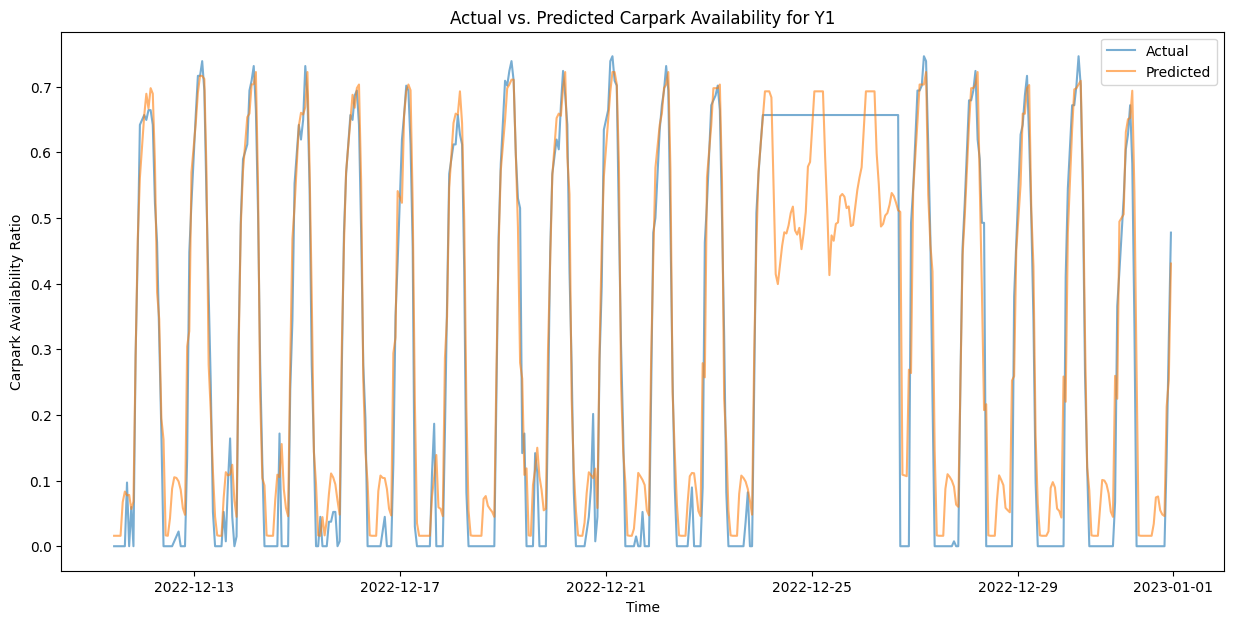

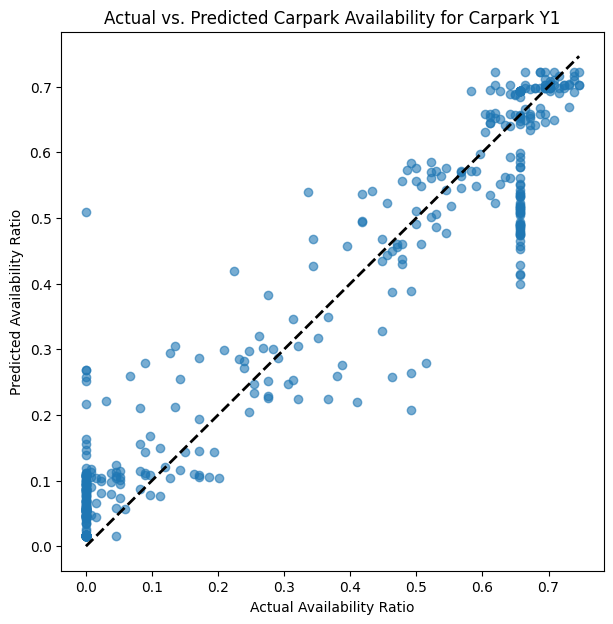

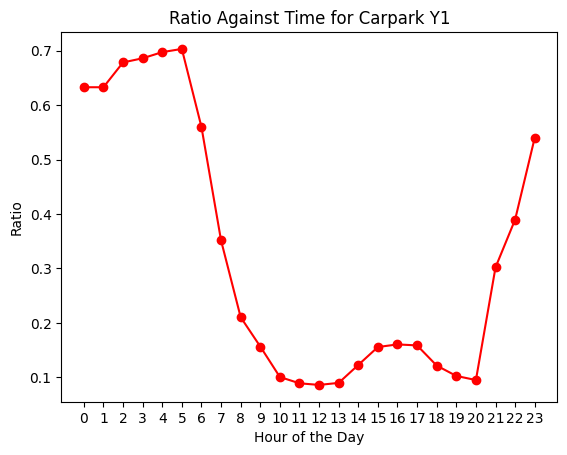

================================== Starting model generation for Carpark Y2... ==================================
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y2_train.json) already exists, loading from file.
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y2_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.0014033222746292668, R2: 0.9035884792134357
[Cross Validation on Train] Mean R2 = 0.8689, Std = 0.0200
[Test] MSE: 0.002226244233831754, R2: 0.8412588162763288


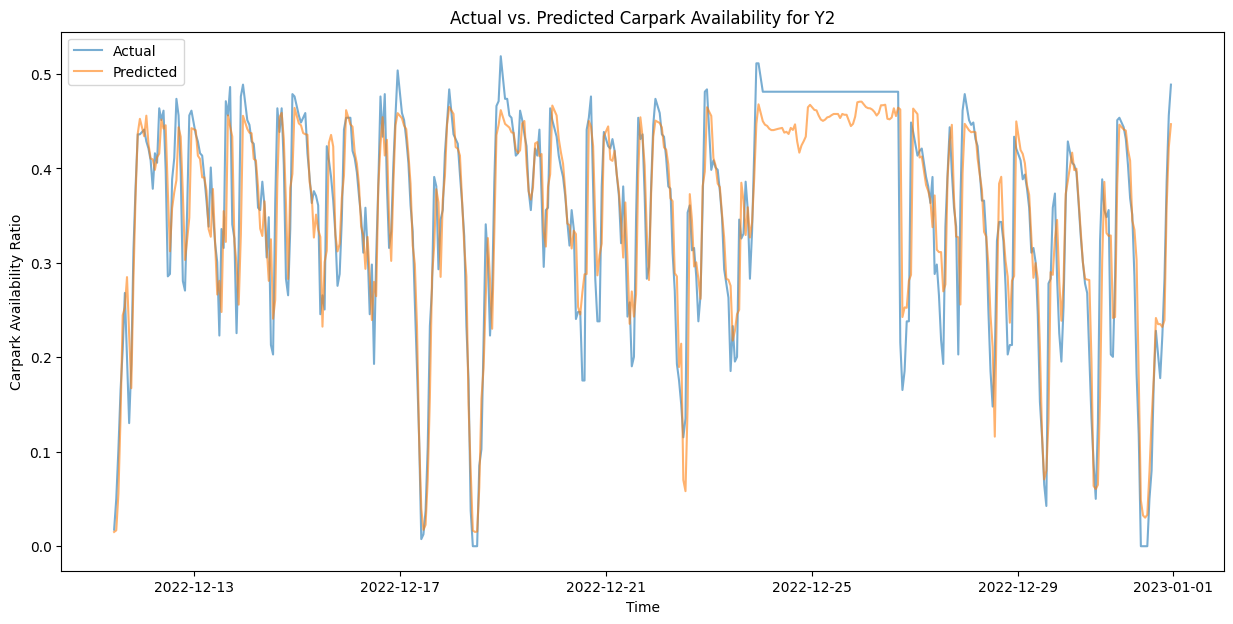

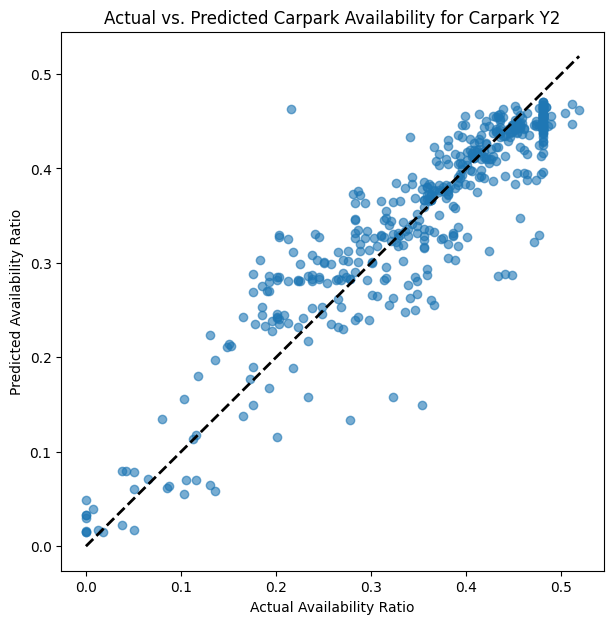

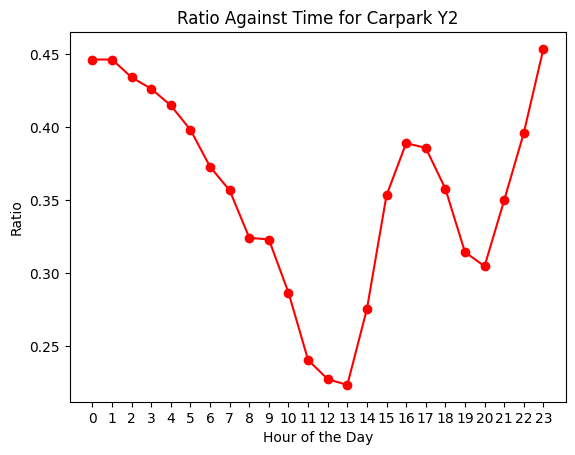

================================== Starting model generation for Carpark Y3... ==================================
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y3_train.json) already exists, loading from file.
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y3_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.0006875409419415745, R2: 0.9753899958372535
[Cross Validation on Train] Mean R2 = 0.9592, Std = 0.0252
[Test] MSE: 0.0007484685196977233, R2: 0.9661665514663104


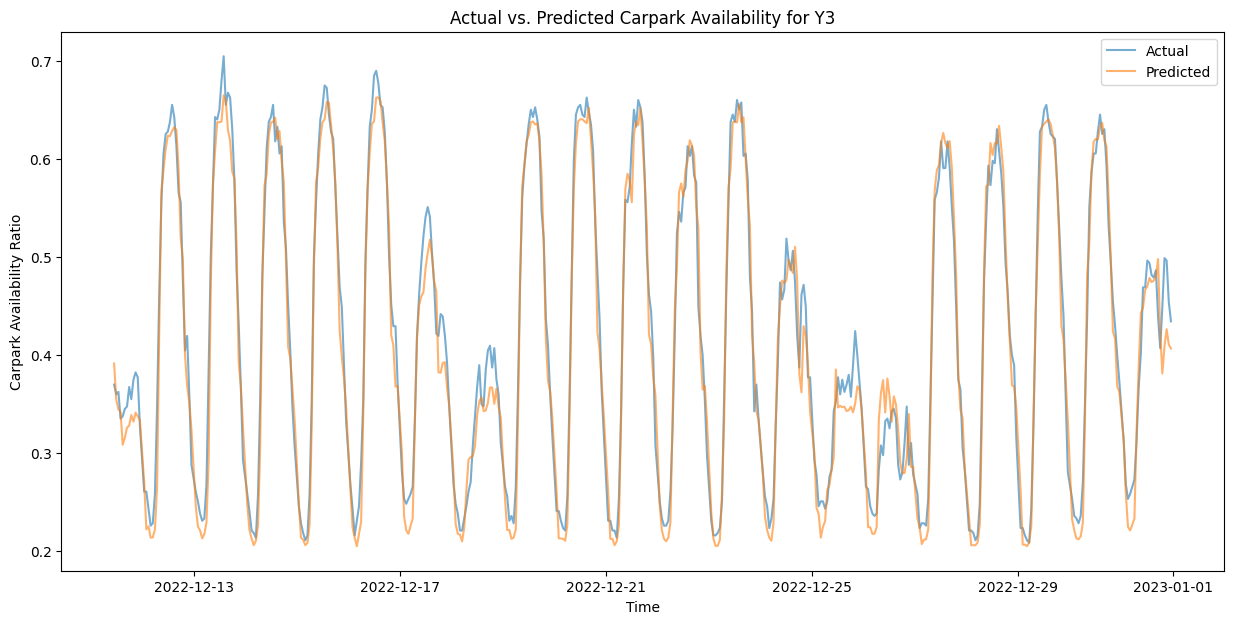

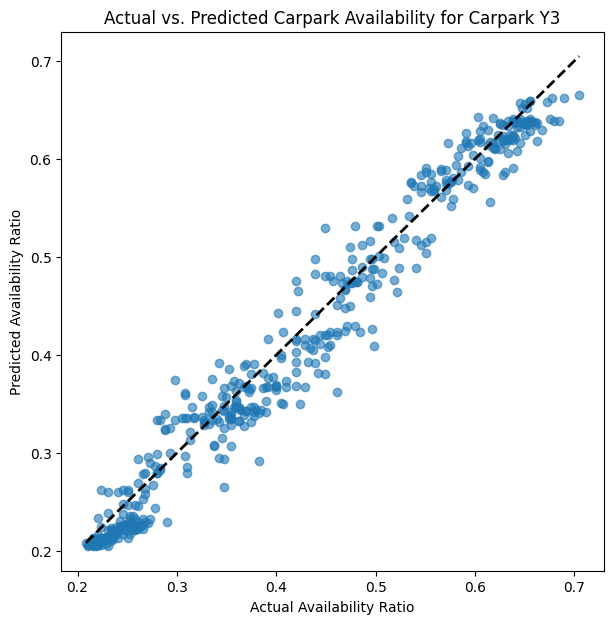

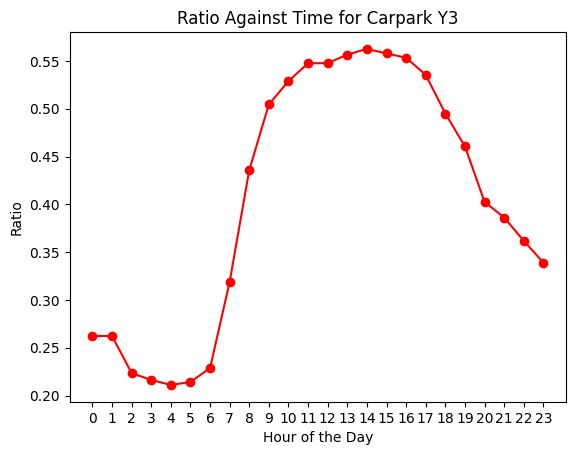

================================== Starting model generation for Carpark Y3M... ==================================
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y3M_train.json) already exists, loading from file.
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y3M_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.0007734406601952223, R2: 0.9736510632757387
[Cross Validation on Train] Mean R2 = 0.9586, Std = 0.0109
[Test] MSE: 0.0009765653667903268, R2: 0.9542914841021195


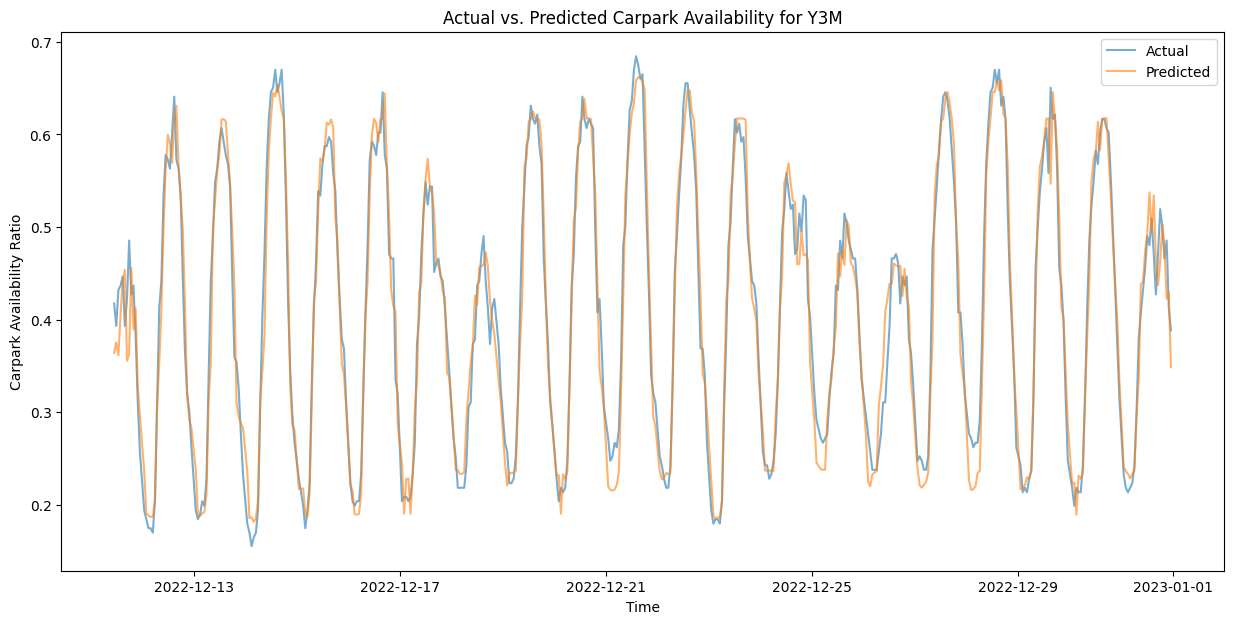

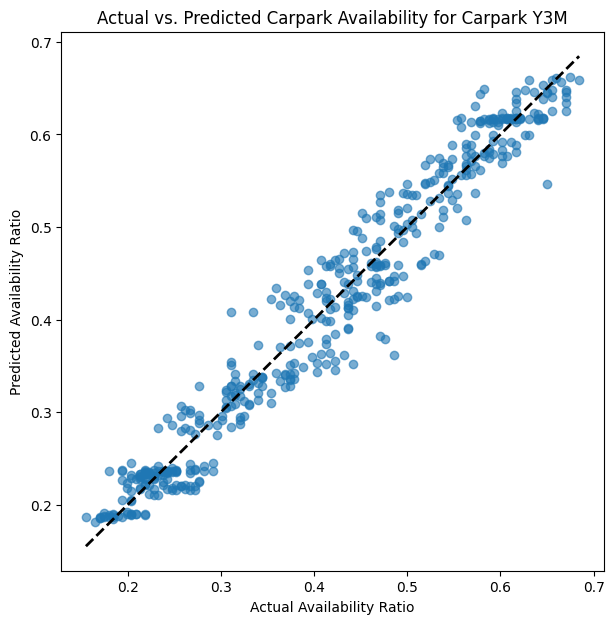

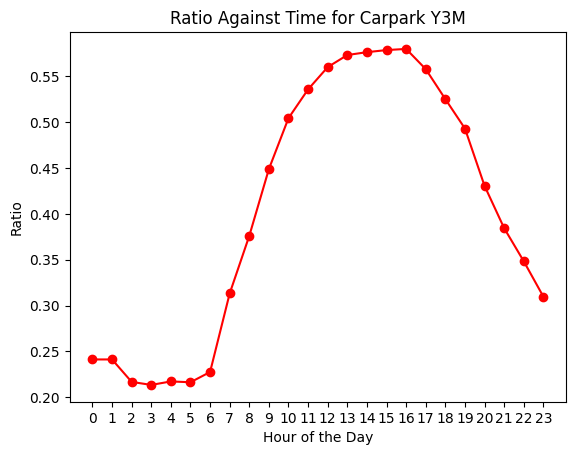

================================== Starting model generation for Carpark Y4... ==================================
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y4_train.json) already exists, loading from file.
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y4_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.0003442175756830225, R2: 0.984905646600435
[Cross Validation on Train] Mean R2 = 0.9749, Std = 0.0142
[Test] MSE: 0.0006417876027117705, R2: 0.9665976842556404


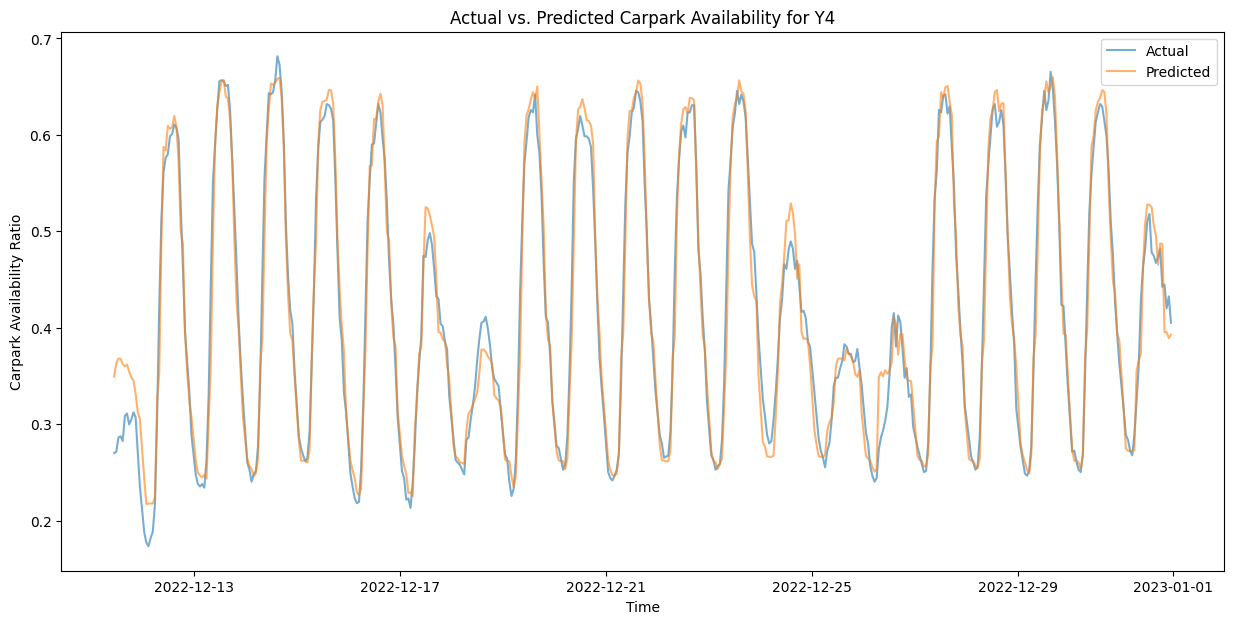

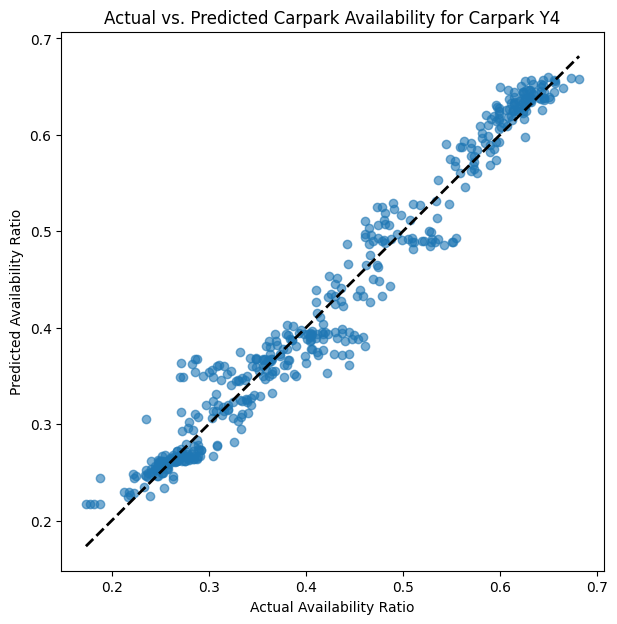

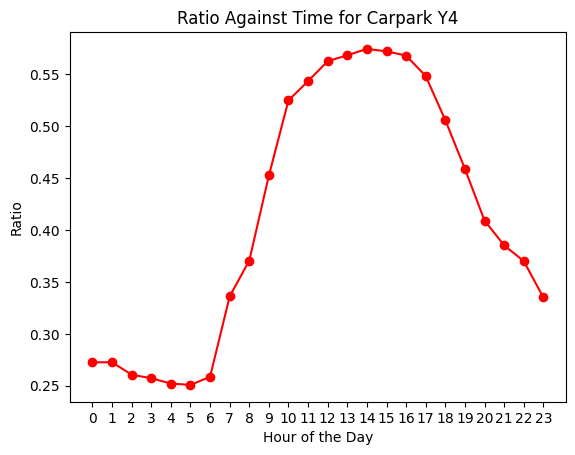

================================== Starting model generation for Carpark Y5... ==================================
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y5_train.json) already exists, loading from file.
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y5_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.0010307562070805873, R2: 0.9606507081097416
[Cross Validation on Train] Mean R2 = 0.8854, Std = 0.0891
[Test] MSE: 0.0008823113695725179, R2: 0.9485449824750021


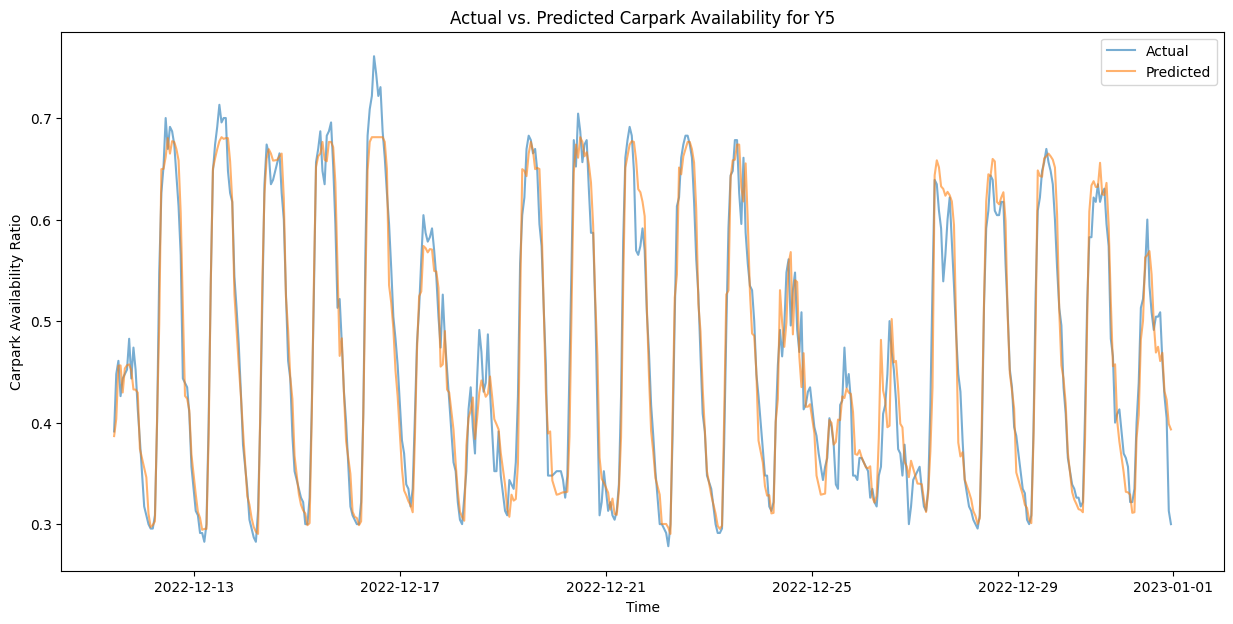

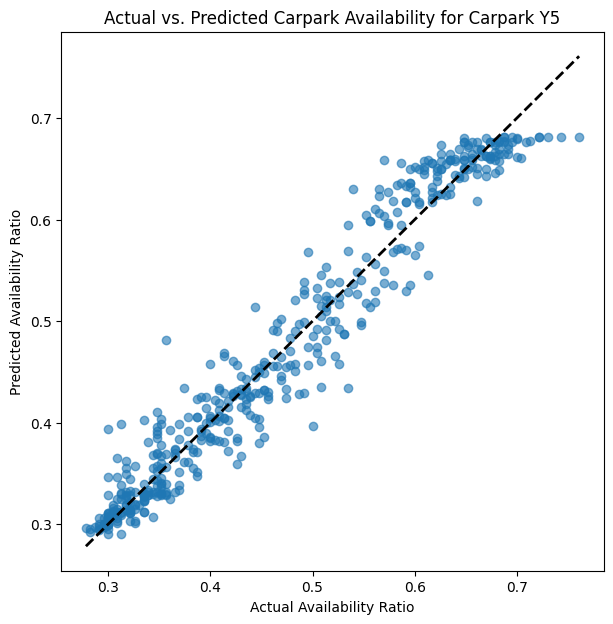

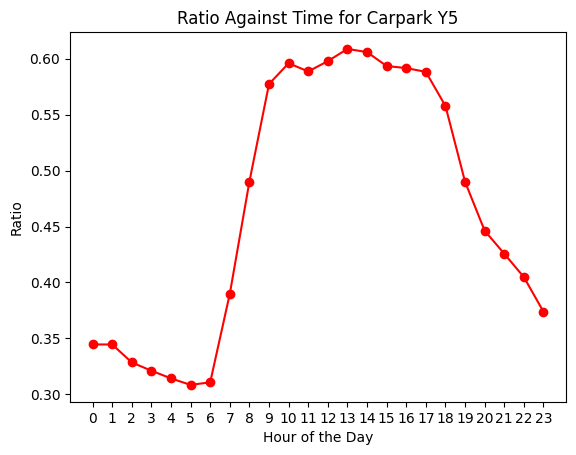

================================== Starting model generation for Carpark Y58... ==================================
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y58_train.json) already exists, loading from file.
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y58_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.003833469588832948, R2: 0.9238213450055912
[Cross Validation on Train] Mean R2 = 0.8692, Std = 0.0481
[Test] MSE: 0.004030473654532534, R2: 0.8815863291015037


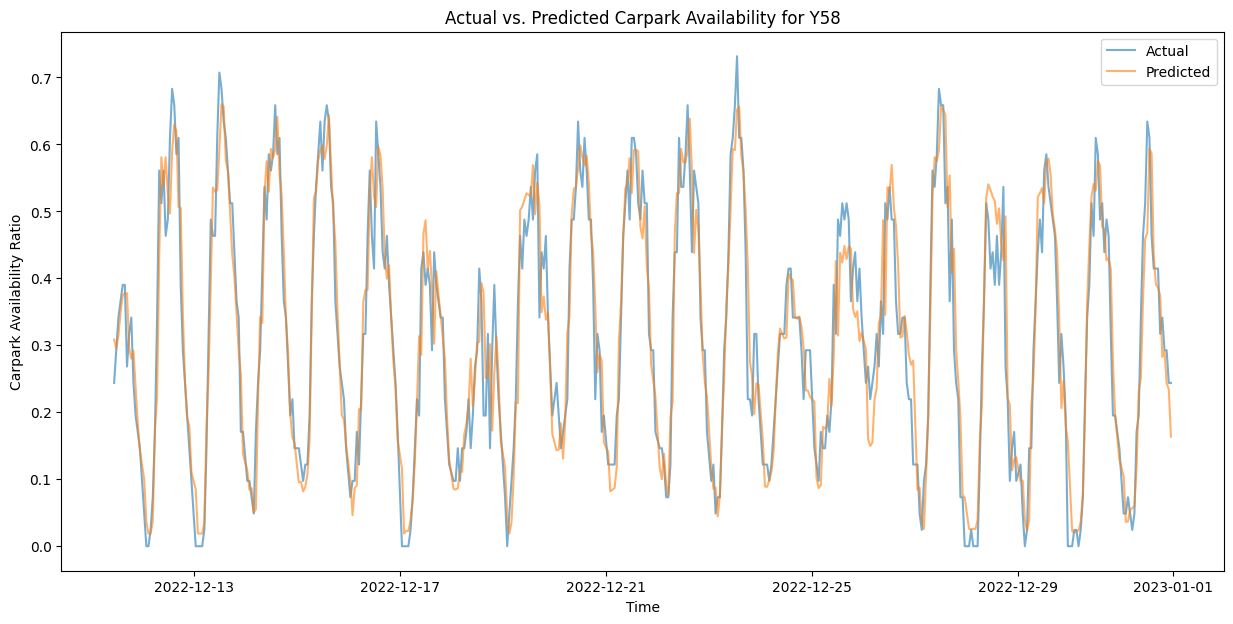

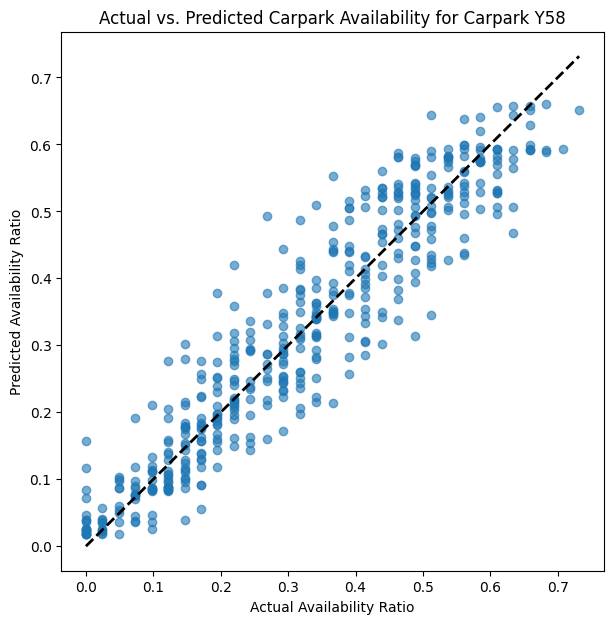

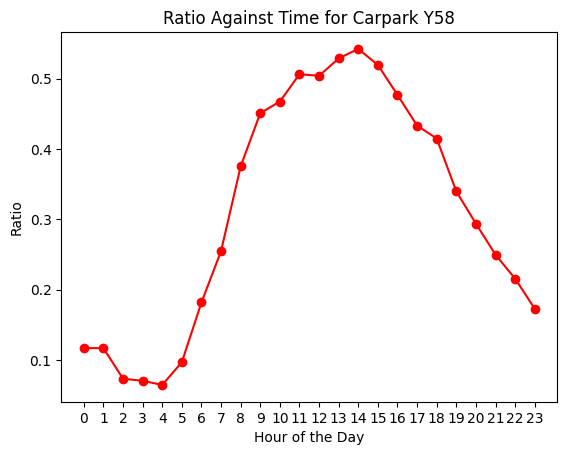

================================== Starting model generation for Carpark Y7... ==================================
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y7_train.json) already exists, loading from file.
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y7_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.0006026600162037226, R2: 0.972792202233495
[Cross Validation on Train] Mean R2 = 0.9456, Std = 0.0425
[Test] MSE: 0.0006012898295932252, R2: 0.9641099457144369


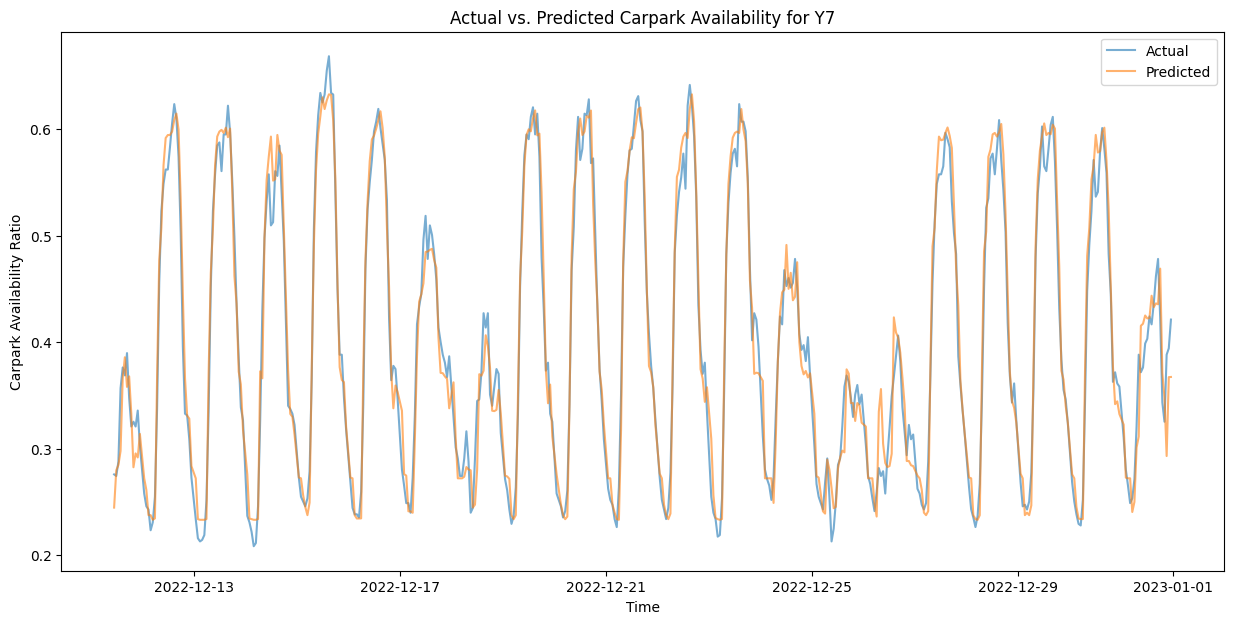

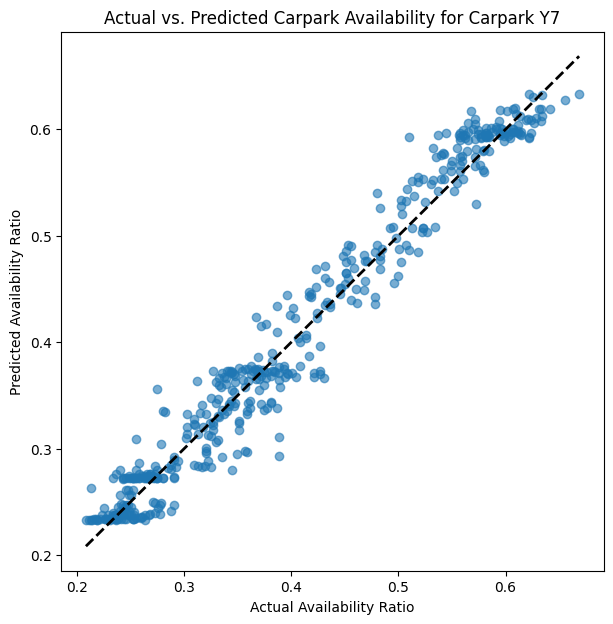

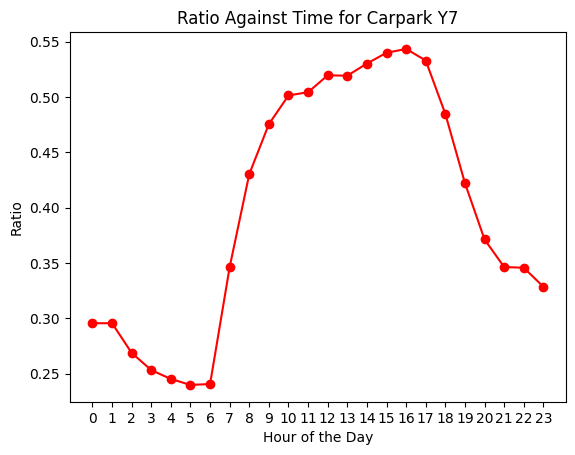

================================== Starting model generation for Carpark Y8... ==================================
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y8_train.json) already exists, loading from file.
File at path (/content/drive/My Drive/EE4211_proj_copy/parking_Y8_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.0004487934726209067, R2: 0.9630233373332289
[Cross Validation on Train] Mean R2 = 0.8746, Std = 0.1533
[Test] MSE: 0.0003830721857694433, R2: 0.945734248912164


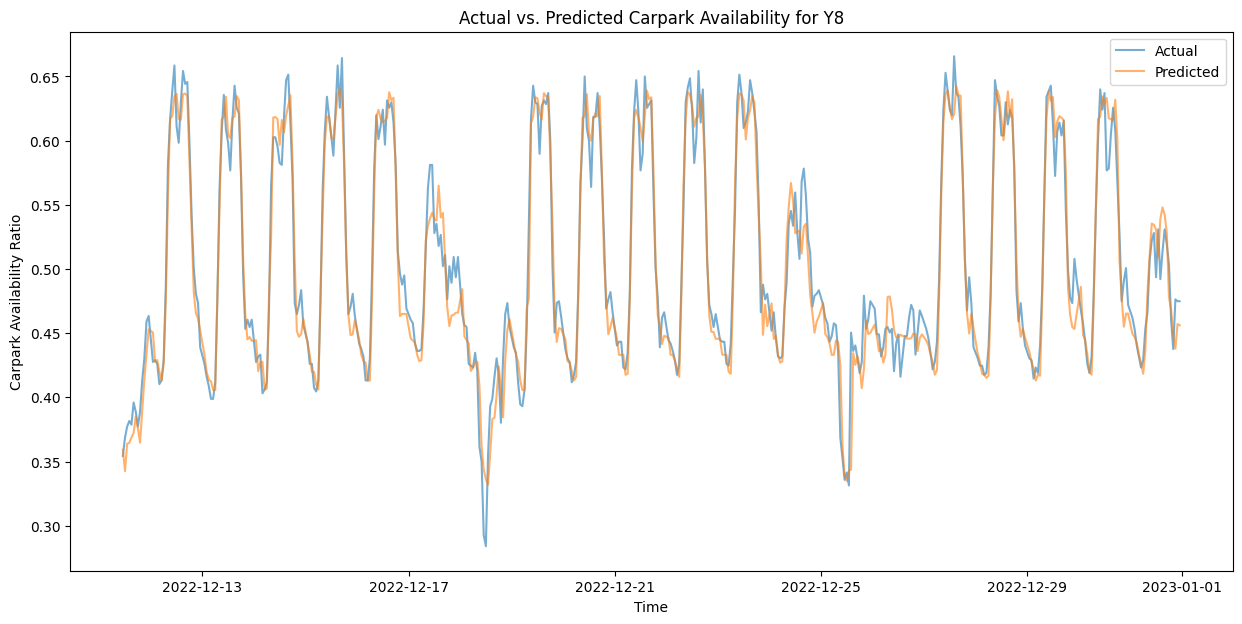

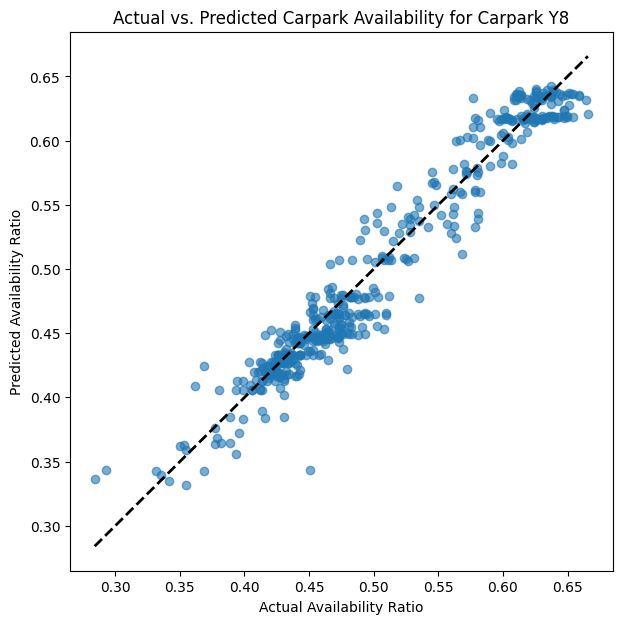

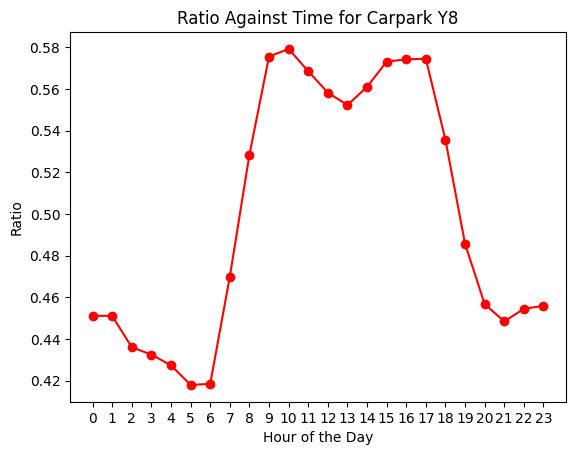

In [ ]:
import time
list_of_carparks = ["Y1", "Y2", "Y3", "Y3M", "Y4", "Y5", "Y58", "Y7", "Y8"]
tot_df = pd.DataFrame()


for i in list_of_carparks:
  print(f'================================== Starting model generation for Carpark {i}... ==================================')
  dataframe_train = extract_parking_data(df_train, i, name="train")
  dataframe_test = extract_parking_data(df_test, i, name="test")
  (X_train, y_train, X_test, y_test) = gen_sets(dataframe_train, dataframe_test)
  pred_test = RandomForest(X_train, y_train, X_test, y_test)
  visualization(X_test, y_test, pred_test, i)
  df = gen_availability(pred_test, y_test, i)
  tot_df = pd.concat([tot_df, df], ignore_index = True)

### Part 8: Generate Heatmap

Heatmaps are generated as HTML files which can be accessed for viewing.

In [ ]:
import folium
from folium import plugins
from branca.element import Figure

# Latitude and longitude of Hawker center we plan on doing our analysis on (Chong Pang Hawker Center).
hawker_lat = 1.43145
hawker_lng = 103.82854

carparks = pd.read_json(f'{shared_path}/nearby.json')
carpark_points = []
carpark_data = []
for num in range(carparks.shape[0]):
  if carparks.iloc[num]["Id"] in list_of_carparks:
    location = carparks.iloc[num]["location"]
    locs = location.split(" ")
    coord = (float(locs[0]), float(locs[1]))
    carpark_points.append(coord)
    carpark_data.append((coord, carparks.iloc[num]["Id"]))


def map_carparks(array, dataframe):
    # Create figure.
    fig = Figure(width = 550, height = 350)

    # Add map to figure.
    centroidMap = folium.Map(width = 550, height = 350,
                   location = [hawker_lat, hawker_lng],
                   zoom_start = 15, min_zoom = 15, max_zoom = 15)
    fig.add_child(centroidMap)

    folium.Marker(
            location=[hawker_lat, hawker_lng],
            popup="Chong Pang Hawker Center",
            icon=folium.Icon(color="green", icon="info-sign"),
        ).add_to(centroidMap)

    for carpark in array:
        point = carpark[0]
        id = carpark[1]
        folium.Marker(
            location=[point[0], point[1]],
            popup=id,
            icon=folium.Icon(color="red", icon="info-sign"),
        ).add_to(centroidMap)

    plugins.HeatMap(df_heatmap, radius = 25, blur = 20).add_to(centroidMap)
    return fig

for i in range(24):
  df_heatmap = pd.DataFrame(carpark_points, columns=["latitude", "longitude"])
  df_heatmap = pd.concat([df_heatmap, tot_df[f"hour {i} ratio"] * 200], ignore_index=True, axis=1)

  figure = map_carparks(carpark_data, df_heatmap)

  folder_path = f'{shared_path}/Heatmaps'
  if not os.path.exists(folder_path):
    os.makedirs()

  figure.save(f"{folder_path}/heatmap_{i}.html")

#### 8.1 Sample Heatmaps

2 sample heatmaps are generated in the cells below. The red icons are the Carparks in the area, while the green icon is the Hawker Centre that we are conducting the analysis around.

In [ ]:
# Sample Heatmap at 12pm around Chong Pang Food Court:
df_heatmap = pd.DataFrame(carpark_points, columns=["latitude", "longitude"])
df_heatmap = pd.concat([df_heatmap, tot_df[f"hour 12 ratio"] * 200], ignore_index=True, axis=1)

figure = map_carparks(carpark_data, df_heatmap)
figure

In [ ]:
# Sample Heatmap at 12am around Chong Pang Food Court:
df_heatmap = pd.DataFrame(carpark_points, columns=["latitude", "longitude"])
df_heatmap = pd.concat([df_heatmap, tot_df[f"hour 0 ratio"] * 200], ignore_index=True, axis=1)

figure = map_carparks(carpark_data, df_heatmap)
figure

## Question 3 Analysis
In our project, we are examining car park spaces in relation to the time of day and their proximity to popular hawker centers. We start by analyzing a dataset from data.gov.sg, which shows the availability of car parks. This data reveals a general trend: early in the morning, around 5 AM, the availability of car parks is at about 45%. As the day progresses, this number slowly increases in a pattern that looks like a U-shaped curve. By 4 PM, the availability usually reaches its peak at 65%, and then it starts decreasing again, following a similar curve, until it goes back to 45% at around 4 AM the next day.

Since we cannot know for sure how car park availability changes every minute of the day, we use Machine Learning as a tool to predict these changes. Machine Learning helps us estimate the availability based on the hour, using models designed for predicting numbers, like Decision Trees, Support Vector Machines, Random Forests, and more advanced techniques like Ensembling and Adaptive Boosting (AdaBoostRegressor).

To add another layer to our analysis, we cross-reference the car park codes with the DataMall API to find their exact locations. We then gather data on hawker centers from a GEOJSON file on data.gov.sg and pinpoint their locations too.

Our focus then shifts to identifying car parks that are within 200 meters of these hawker centers. We create a new dataset, 'hawker_nearby.json', which links car parks to nearby hawker centers. For example, we found that the Bukit Merah Central Food Centre has several car parks in its vicinity, each with its own ID, address, and coordinates.

```
"Bukit Merah Central Blk 163 (Bukit Merah Central Food Centre)": [
        {
            "carpark_id": "HE12",
            "carpark_add": "BLK 78/81 REDHILL LANE",
            "carpark_coord": "1.2882100231309097 103.81865062406243"
        },
        {
            "carpark_id": "RHM",
            "carpark_add": "BLK 88A REDHILL CLOSE",
            "carpark_coord": "1.2864639274816887 103.81857760519375"
        },
        {
            "carpark_id": "BM29",
            "carpark_add": "BLK 163 BUKIT MERAH CENTRAL",
            "carpark_coord": "1.283634706091155 103.81709921259974"
        }]
  ```

By combining these datasets, we can understand how car park availability correlates with the proximity to hawker centers, particularly during meal times. This analysis is valuable in the context of a data science project because it provides insights into urban planning and public convenience. It helps to answer questions like: How does the demand for car parks change throughout the day? Are there enough parking spaces near popular dining areas? This understanding could guide city planners in improving parking solutions and managing traffic better, especially during peak dining hours.

In conclusion, our project expands beyond the initial proposal by integrating different datasets and applying Machine Learning to draw meaningful conclusions about car park availability in relation to hawker centers. This approach demonstrates the power of data science in solving real-world problems and improving everyday life.


## Question 3 Practical Action Writeup

Using our knowledge in data science, we have developed a dynamic heatmap that vividly illustrates carpark availability around a central food hub. This tool provides a clear, predictive real-time picture of carpark space occupancy. The heatmap's gradient colors indicate availability — cool colors signify open spaces, while warmer tones suggest limited or no availability. Using such visual aids in conveying information improves the drivers’ interaction with the urban space when it comes to finding parking lots.

By implementing this heatmap within a user-friendly app, we offer drivers a powerful resource to locate available parking efficiently, thus helping to reduce the time spent in searching for parking. Not only does this help in cutting down on fuel consumption it also helps in easing traffic congestion. This proactive approach to parking management not only enhances the individual's experience but also promotes a more sustainable urban environment by alleviating the pressure on city infrastructure.

Since the model generated targets the carpark availability of each individual carpark instead of taking the aggregate values of all, it gives users a more comprehensive picture of which carparks are full and which are more empty. This therefore, helps drivers find parking lots that aren't full and steers them clear of places where it's hard to find a spot near food centers. This not only helps spread out the parked cars more evenly and makes the best use of the parking we have, it also enables users to have a streamlined and seamless dining experience, connecting them much quicker with the food they desire. This is fundamentally a big move towards using data to make city living and getting around easier, while adding to everyone’s convenience.